# Sensitivity to the number of years validated on: 

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [3]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils_kb as limkb
import LIM_building as limbuild
import LIM_stats_kb as statskb

sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [4]:
def get_title_strings(var,exp_setup,forecast):
    if 'cmip6' in exp_setup['train_dsource']: 
        tcmip='CMIP6'
    elif 'era' in exp_setup['train_dsource']:
        tcmip=''
    elif 'satellite' in exp_setup['train_dsource']: 
        tcmip=''
    elif 'lme' in exp_setup['train_dsource']: 
        tcmip=''
    else: 
        tcmip='CMIP5'

    if 'cmip6' in exp_setup['valid_dsource']: 
        vcmip='CMIP6'
    elif 'era' in exp_setup['valid_dsource']:
        vcmip=''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vcmip=''
    elif 'lme' in exp_setup['valid_dsource']: 
        vcmip=''
    else: 
        vcmip='CMIP5'

    # start_tim = exp_setup['nyears_startvalid']
    # end_tim = exp_setup['nyears_startvalid']+(exp_setup['nyearsvalid']*12)
    valid_yrs_str = (str(forecast['var_dict_valid'][var]['time'][0])[:4]+'_'+
                     str(forecast['var_dict_valid'][var]['time'][-1])[:4])

    if 'hist' in exp_setup['train_dsource']:
        texp = 'Historical'
    elif 'lm' in exp_setup['train_dsource']: 
        texp = 'LM'
    elif 'ssp585' in exp_setup['train_dsource']: 
        texp = 'SSP585'
    elif 'era5' in exp_setup['train_dsource']: 
        texp = 'ERA5'
    elif 'satellite' in exp_setup['train_dsource']: 
        texp = 'Satellite'
    elif 'lme' in exp_setup['train_dsource']: 
        texp = 'LME'

    if 'hist' in exp_setup['valid_dsource']:
        vexp = 'Historical'
    elif 'lm' in exp_setup['valid_dsource']: 
        vexp = 'LM'
    elif 'ssp585' in exp_setup['valid_dsource']: 
        vexp = 'SSP585'
    elif 'era5' in exp_setup['valid_dsource']: 
        vexp = 'ERA5'
    elif 'satellite' in exp_setup['valid_dsource']: 
        vexp = 'Satellite'
    elif 'lme' in exp_setup['valid_dsource']: 
        vexp = 'LME'

    if 'cesm2' in exp_setup['train_dsource']:
        tmod = 'CESM2'
    elif 'mpi' in exp_setup['train_dsource']: 
        tmod = 'MPI'
    elif 'gfdl' in exp_setup['train_dsource']: 
        tmod = 'GFDL'
    elif 'ccsm4' in exp_setup['train_dsource']: 
        tmod = 'CCSM4'
    elif 'era5' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'satellite' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'lme' in exp_setup['train_dsource']: 
        tmod = 'CESM'

    if 'cesm2' in exp_setup['valid_dsource']:
        vmod = 'CESM2'
    elif 'mpi' in exp_setup['valid_dsource']: 
        vmod = 'MPI'
    elif 'gfdl' in exp_setup['valid_dsource']: 
        vmod = 'GFDL'
    elif 'ccsm4' in exp_setup['valid_dsource']: 
        vmod = 'CCSM4'
    elif 'era5' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'lme' in exp_setup['valid_dsource']: 
        vmod = 'CESM'

    if exp_setup['Weight'] is True: 
        wt_addin = ' '
    else: 
        wt_addin = '(no area weighting)'

    if exp_setup['detrend'] is True: 
        tr_addin = ' '
    else: 
        tr_addin = ' (trended)'
        
    return tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, wt_addin, tr_addin

In [5]:
def plot_lagged_performance_1var(fig,axs,var,forecast_validation_lags,ar1cast_lags,
                                 tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                 wt_addin, tr_addin):

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['corr_tot'][:]**2, 
               label='Correlation',linewidth=4)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['corr_tot'][:-1]**2, 
               label='AR(1) Correlation',linewidth=4, 
               linestyle='--', color='tab:blue',alpha=0.5)

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['ce_tot'][:],
               label='CE',linewidth=3.0)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['ce_tot'][:-1],
               label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
    axs.set_ylim(0,1)
    axs.set_xlim(0,8)
    axs.grid(axis='both')
    
    return 

In [6]:
def plot_monthly_performance_1var(fig,axs,var,forecast_validation_lags,ar1cast_lags,
                                  tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                  wt_addin, tr_addin):
    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['gm_rmse'][:], 
               label='LIM',linewidth=3.0, color='purple')
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
               label='AR(1)',linewidth=3.0, linestyle='--', color='purple',alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
#    axs.set_ylim(0,0.018)
    axs.set_xlim(0,6)
    axs.grid(axis='both')
    
#    axs.axhline(1.0, color='k', linewidth=2, label='No skill')
    
    return 

In [7]:
plt.rcParams['figure.dpi']=300

In [8]:
ntrunc = 50 # EOF truncation for individual fields (reduced-state space)
ntrunc_sic = 50
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic = 50
#modes_sic = 20

mo='all'
#mo=0
lags = [0,1,2,3,4,5,6,7,8]

#model = 'satellite'
#model = 'cmip6_mpi_hist'
#model = 'era5'
model = 'cesm_lme'
yrend = 1650

nyrs_valid = [200,175,150,125,100,75,50,25,10]

# forecast lead time in months that defines the LIM training
tau = 1

# variables to include in the LIM (note "vars" is a Python command)
limvars = ['tas','psl','zg','tos','sit','sic']
#limvars = ['sic']

data_dir = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid/'

In [9]:
folder = 'last_millennium/'
filename_os = ('LIMcast_'+model+'_002_ntrain_850_'+str(yrend)+
               '_validyrs_'+str(1651)+'_'+str(1850)+
               '_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')

print('Loading '+data_dir+folder+filename_os)

experiment_os =  pickle.load(open(data_dir+folder+filename_os, 'rb'))

LIMd_os = experiment_os['LIMd']

Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl


In [10]:
rmse_all = {}
ar1_rmse_all = {}

for n,yrvalid in enumerate(nyrs_valid):
    print(yrvalid)
    startyr = 1651
    
    if (1851-startyr)/yrvalid >1: 
        nloop = int(np.floor((1851-startyr)/yrvalid))
    else: 
        nloop = 1
    
    print(nloop)
        
    rmse_sic_os = np.zeros((nloop,len(lags)-1))
    ar1_rmse_sic_os = np.zeros((nloop,len(lags)-1))
    
    for i in range(nloop): 
        startyr = 1651
        startyr = startyr+i*yrvalid
        endyr = startyr+yrvalid-1
        
        folder = 'last_millennium/'
        filename_os = ('LIMcast_'+model+'_002_ntrain_850_'+str(yrend)+
                       '_validyrs_'+str(startyr)+'_'+str(endyr)+
                       '_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl')

        print('Loading '+data_dir+folder+filename_os)

        experiment_os =  pickle.load(open(data_dir+folder+filename_os, 'rb'))

        LIMd_os = experiment_os['LIMd']
        exp_setup_os = experiment_os['forecast']['exp_setup']
        forecast_os = experiment_os['forecast']
        forecast_validation_lags_os = experiment_os['forecast_validation_lags']
        ar1cast_lags_os = experiment_os['ar1cast_lags']

        [tcmip_os, vcmip_os, valid_yrs_str_os, texp_os, 
         vexp_os, tmod_os, vmod_os, wt_addin_os, tr_addin_os] = get_title_strings('sic',exp_setup_os,forecast_os)

        rmse_sic_os[i,:] = forecast_validation_lags_os['validation_stats_lags']['sic']['gm_rmse'][1:]
        ar1_rmse_sic_os[i,:] = ar1cast_lags_os['validation_stats_ar1_lags']['sic']['gm_rmse'][1:]
    
    rmse_all[yrvalid] = rmse_sic_os
    ar1_rmse_all[yrvalid] = ar1_rmse_sic_os

200
1
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1850_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl
175
1
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1825_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl
150
1
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1800_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl
125
1
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1775_tas50L40_psl50L40_zg50L40_tos50L40_sit50L40_sic50L40_20211202.pkl
100
2
Loading /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/nvalid/last_millennium/LIMcast_cesm_lme_002_ntrain_850_1650_validyrs_1651_1750_tas50L

In [11]:
# colors = ['royalblue', 'darkcyan', 'darkblue','firebrick', 'salmon', 'peru', 'orange',
#           'mediumpurple','m', 'indigo', 'k']

cmap = matplotlib.cm.get_cmap('viridis_r')

move = 0.8/len(nyrs_valid)
colors = [cmap(i) for i in np.arange(0.1,1,move)]

In [12]:
gm_rmse_all_full = pickle.load(open('sic_cesm_lme_climotology_ntraining_years.pkl', 'rb'))

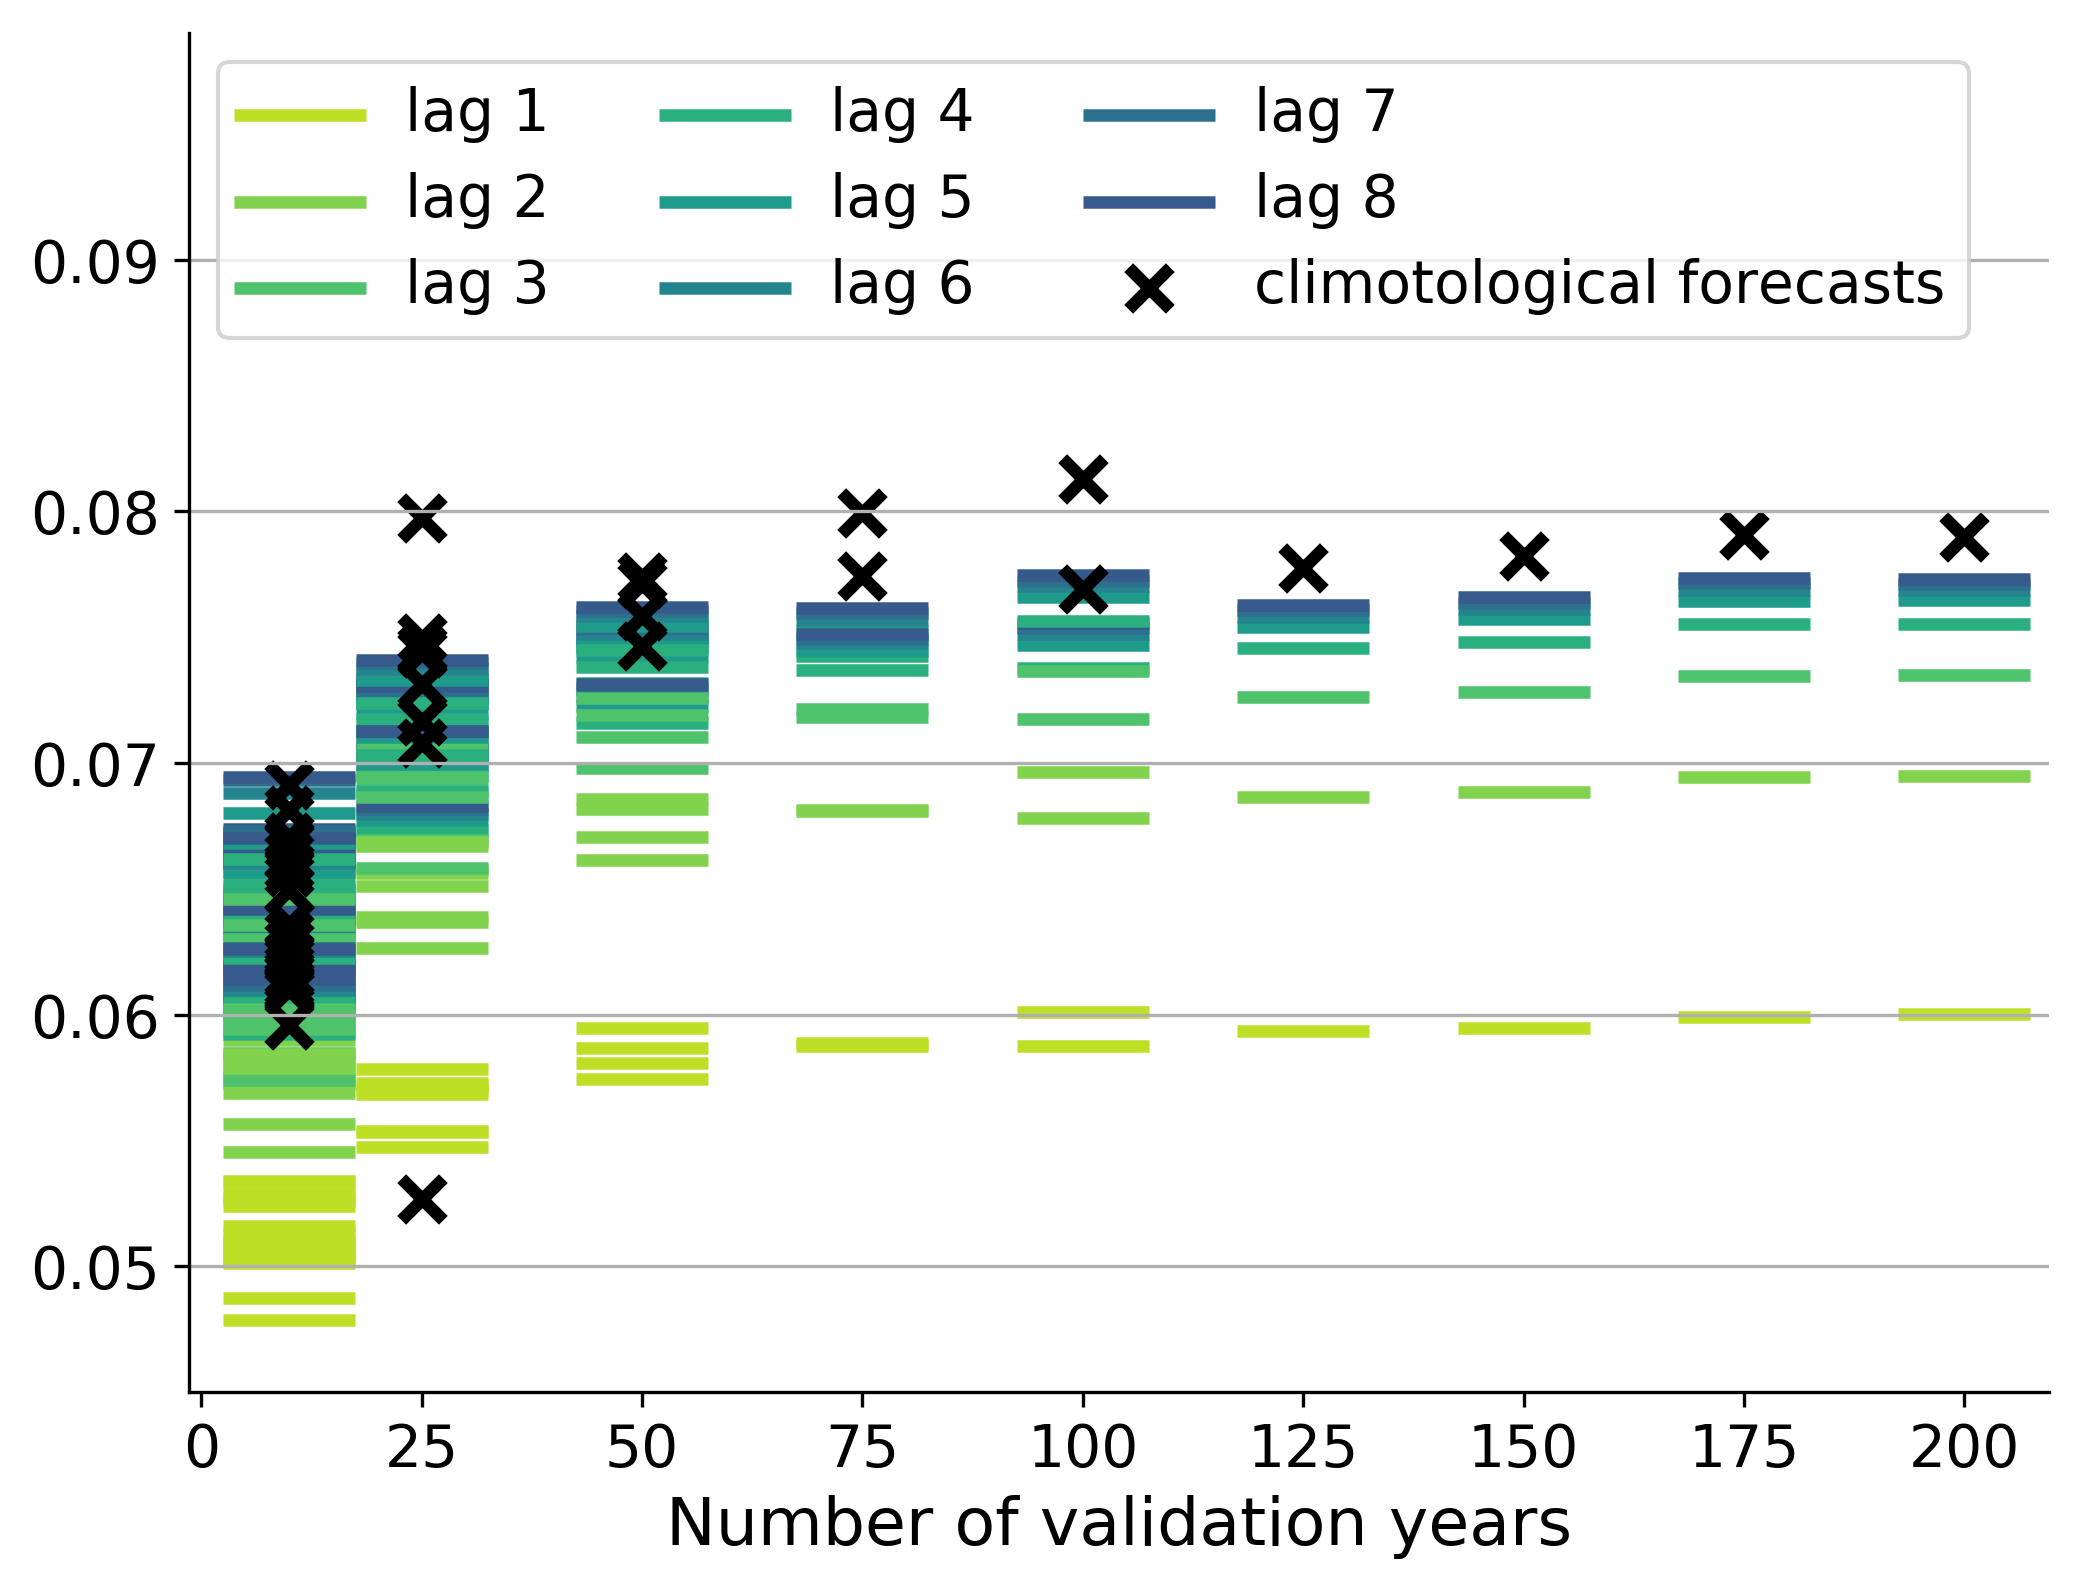

In [13]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

nloop = [1,1,1,1,2,2,4,8,20]
nyrs_valid = [200,175,150,125,100,75,50,25,10]

for y,yrvalid in enumerate(nyrs_valid):
#     startyr = 1651
    
#     if (1851-startyr)/yrvalid >1: 
#         nloop = int(np.floor((1851-startyr)/yrvalid))
#     else: 
#         nloop = 1
    
    for i in range(nloop[y]):
        if y <1: 
            ax.scatter(yrvalid,rmse_all[yrvalid][i,0], linewidth=3, marker='_', s=1000, 
                       color=colors[0], label='lag 1')
            ax.scatter(yrvalid,rmse_all[yrvalid][i,1], linewidth=3, marker='_', s=1000, 
                       color=colors[1], label='lag 2')
            ax.scatter(yrvalid,rmse_all[yrvalid][i,2], linewidth=3, marker='_', s=1000, 
                       color=colors[2], label='lag 3')
            ax.scatter(yrvalid,rmse_all[yrvalid][i,3], linewidth=3, marker='_', s=1000, 
                       color=colors[3], label='lag 4')
            ax.scatter(yrvalid,rmse_all[yrvalid][i,4], linewidth=3, marker='_', s=1000, 
                       color=colors[4], label='lag 5')
            ax.scatter(yrvalid,rmse_all[yrvalid][i,5], linewidth=3, marker='_', s=1000, 
                       color=colors[5], label='lag 6')
            ax.scatter(yrvalid,rmse_all[yrvalid][i,6], linewidth=3, marker='_', s=1000, 
                       color=colors[6], label='lag 7')
            ax.scatter(yrvalid,rmse_all[yrvalid][i,7], linewidth=3, marker='_', s=1000, 
                       color=colors[7], label='lag 8')
        
        else:
            ax.scatter(yrvalid,rmse_all[yrvalid][i,0], linewidth=3, marker='_', s=1000, color=colors[0])
            ax.scatter(yrvalid,rmse_all[yrvalid][i,1], linewidth=3, marker='_', s=1000, color=colors[1])
            ax.scatter(yrvalid,rmse_all[yrvalid][i,2], linewidth=3, marker='_', s=1000, color=colors[2])
            ax.scatter(yrvalid,rmse_all[yrvalid][i,3], linewidth=3, marker='_', s=1000, color=colors[3])
            ax.scatter(yrvalid,rmse_all[yrvalid][i,4], linewidth=3, marker='_', s=1000, color=colors[4])
            ax.scatter(yrvalid,rmse_all[yrvalid][i,5], linewidth=3, marker='_', s=1000, color=colors[5])
            ax.scatter(yrvalid,rmse_all[yrvalid][i,6], linewidth=3, marker='_', s=1000, color=colors[6])
            ax.scatter(yrvalid,rmse_all[yrvalid][i,7], linewidth=3, marker='_', s=1000, color=colors[7])
            
    for i in range((nloop[y])):
        if y <1:     
            ax.scatter(yrvalid,gm_rmse_all_full[yrvalid][i],linewidth=3, marker='x', s=100, 
                      color='k', label = 'climotological forecasts')
        else:   
            ax.scatter(yrvalid,gm_rmse_all_full[yrvalid][i],linewidth=3, marker='x', s=100, color='k')
            
#ax.plot(np.array(nyrs_valid),gm_rmse, linewidth=4, color='k', label='climotological forecast')

#ax.set_xlim(0,8)
ax.set_ylim(0.045,0.099)
#ax.legend(bbox_to_anchor=[1,0.6],fontsize=14, ncol=2, frameon=False)
ax.legend(loc='upper left',fontsize=14, ncol=3)
#ax.set_ylabel('Arctic Mean RMSE (%)', fontsize=16)
ax.set_xlabel('Number of validation years', fontsize=16)
#ax.set_xticklabels(nyrs_valid, fontsize=14)
#ax.set_xticks(fontsize=14)
#ax.set_title('Out of Sample Validation', fontsize=18)
ax.tick_params(labelsize=14)

plt.grid(axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

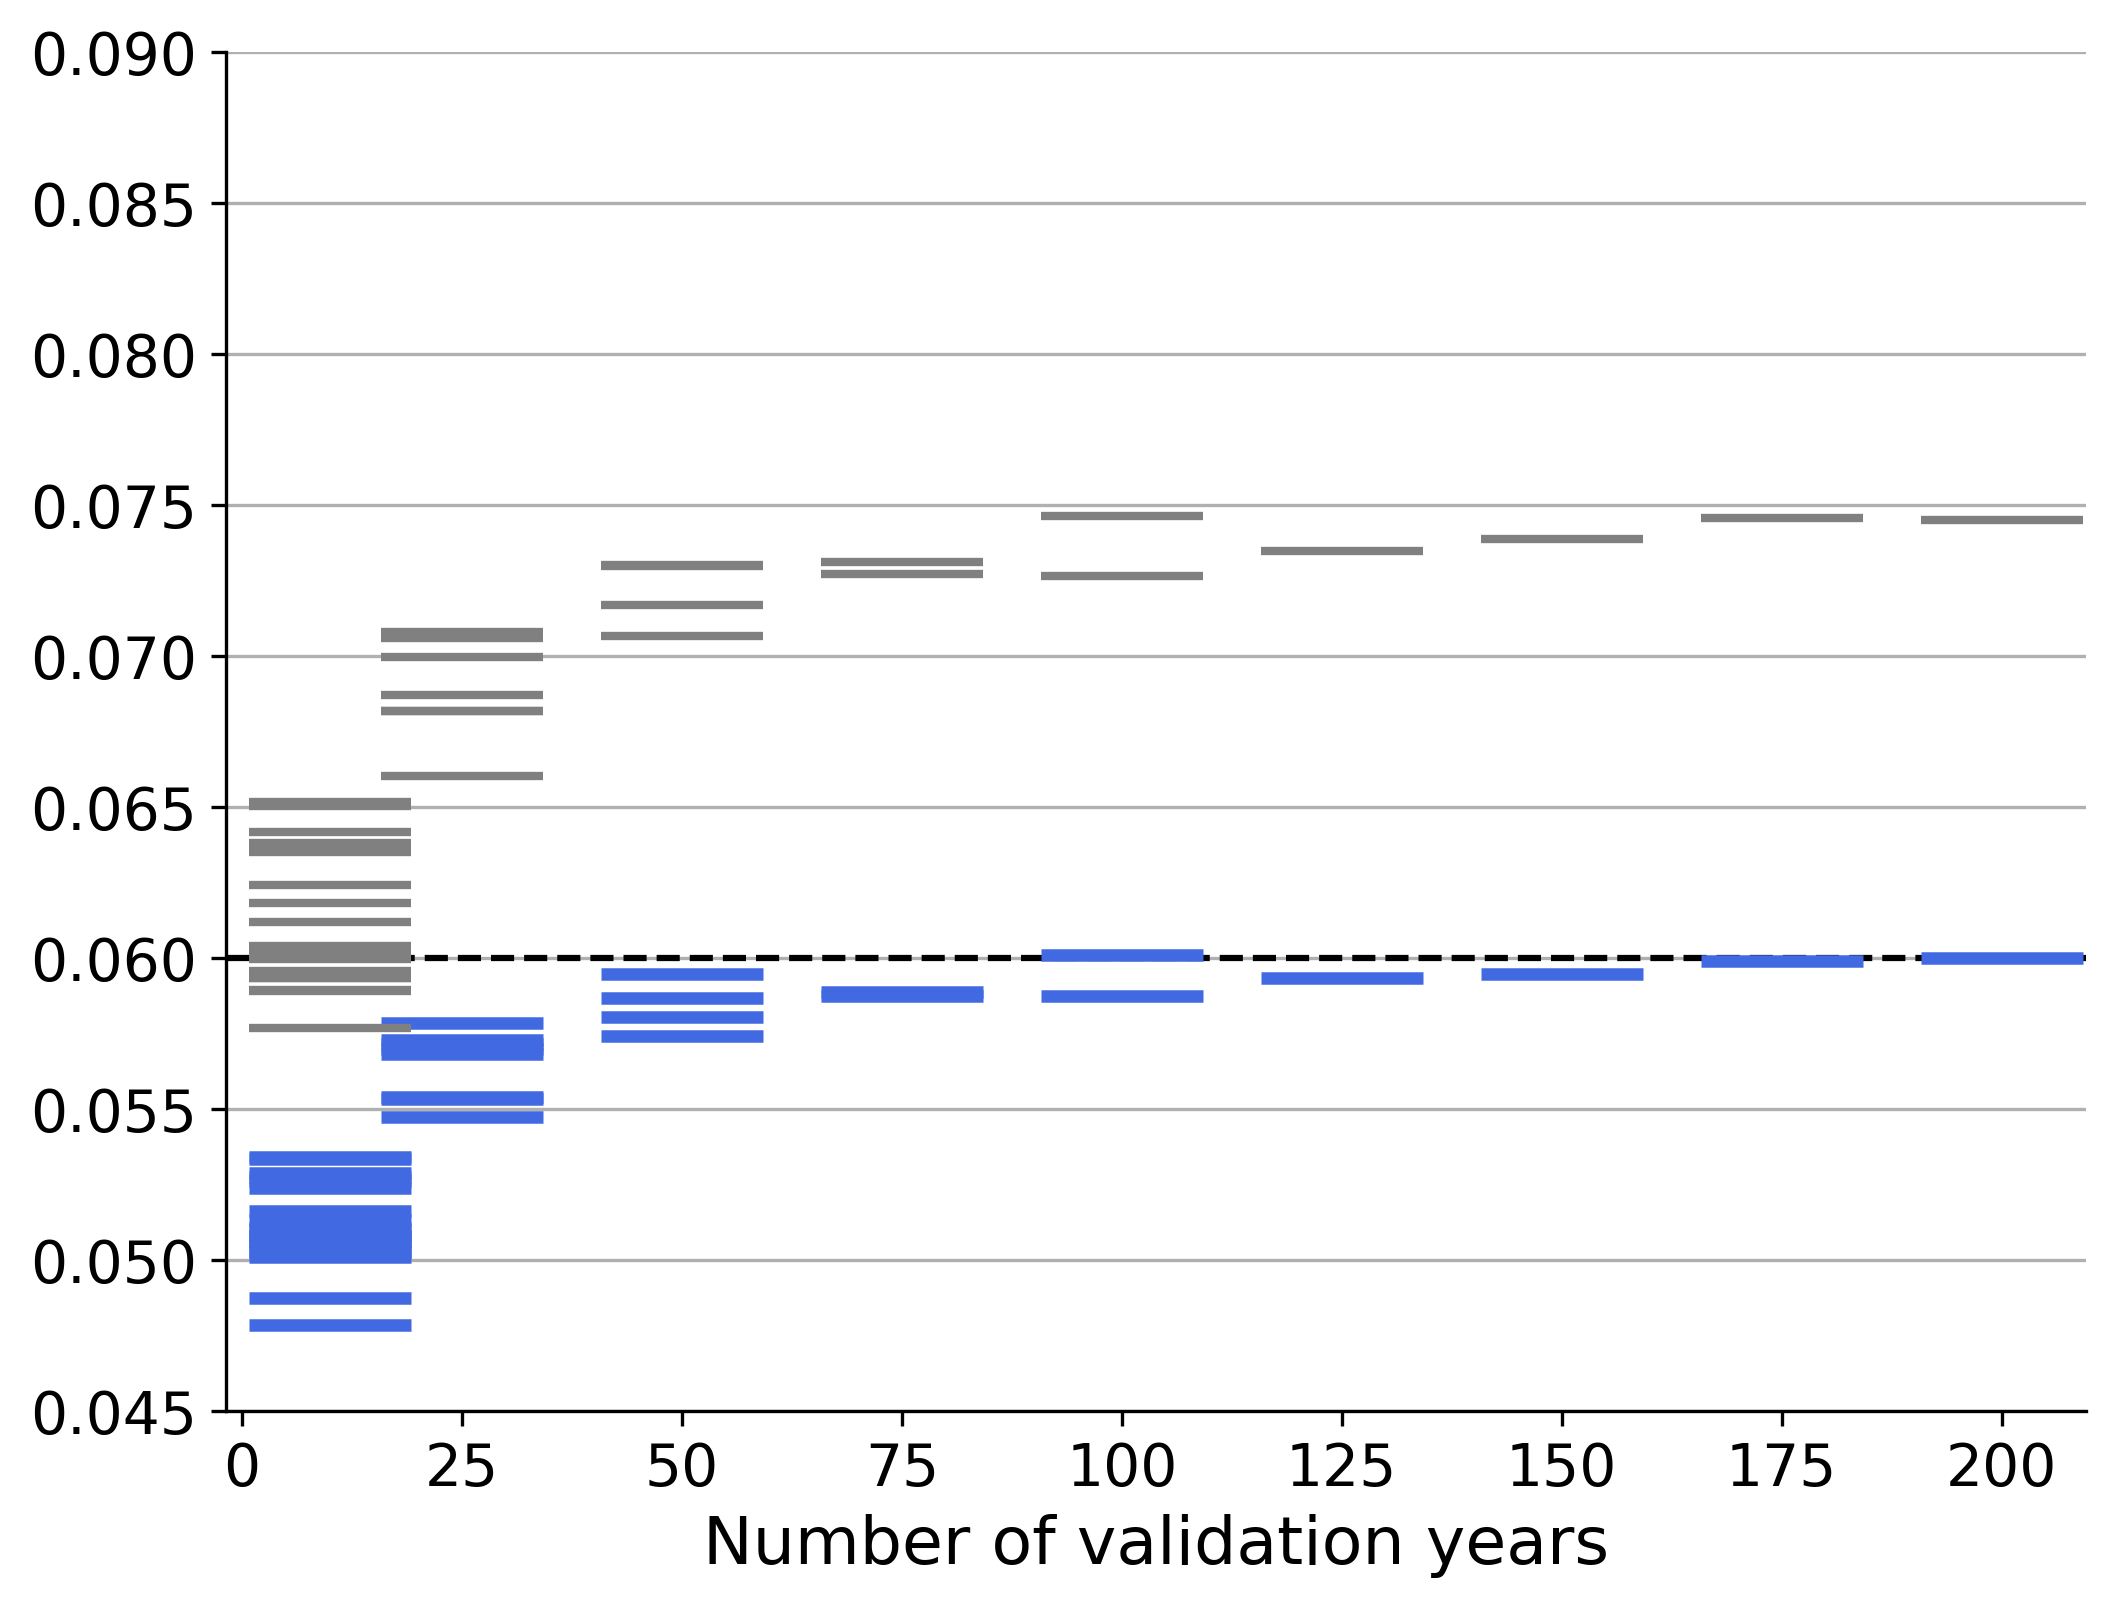

In [14]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

nloop = [1,1,1,1,2,2,4,8,20]
nyrs_valid = [200,175,150,125,100,75,50,25,10]

plt.axhline(0.06, color='k', linestyle='--',zorder=5)

for y,yrvalid in enumerate(nyrs_valid):
#     startyr = 1651
    
#     if (1851-startyr)/yrvalid >1: 
#         nloop = int(np.floor((1851-startyr)/yrvalid))
#     else: 
#         nloop = 1
    
    for i in range(nloop[y]):
        if y <1: 
            ax.scatter(yrvalid,rmse_all[yrvalid][i,0], linewidth=3, marker='_', s=1500, 
                       color='royalblue', label='LIM lag 1',zorder=15)
            ax.scatter(yrvalid,ar1_rmse_all[yrvalid][i,0], linewidth=2, marker='_', s=1500, 
                       color='gray', label='AR1 lag 1',zorder=15)
        else:
            ax.scatter(yrvalid,rmse_all[yrvalid][i,0], linewidth=3, marker='_', s=1500, color='royalblue',zorder=15)
            ax.scatter(yrvalid,ar1_rmse_all[yrvalid][i,0], linewidth=2, marker='_', s=1500, color='gray',zorder=15)

#ax.set_xlim(0,8)
ax.set_ylim(0.045,0.09)
#ax.legend(bbox_to_anchor=[1,0.6],fontsize=14, ncol=2, frameon=False)
#ax.legend(loc='upper left',fontsize=14)
#ax.set_ylabel('Arctic Mean RMSE (%)', fontsize=16)
ax.set_xlabel('Number of validation years', fontsize=16)
#ax.set_xticklabels(nyrs_valid, fontsize=14)
#ax.set_xticks(fontsize=14)
#ax.set_title('Out of Sample Validation', fontsize=18)
ax.tick_params(labelsize=14)

plt.grid(axis='y',zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [15]:
ntrain_data =  pickle.load(open('Ntrain_sensitivity_plot.pkl', 'rb'))
train_length = [100,200,300,400,500,600,700,800,900]
nloop_train = [8,4,3,2,2,1,1,1,1]
ntrain_data.keys()

dict_keys(['ar1_rmse_sic', 'rmse_sic'])

In [16]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

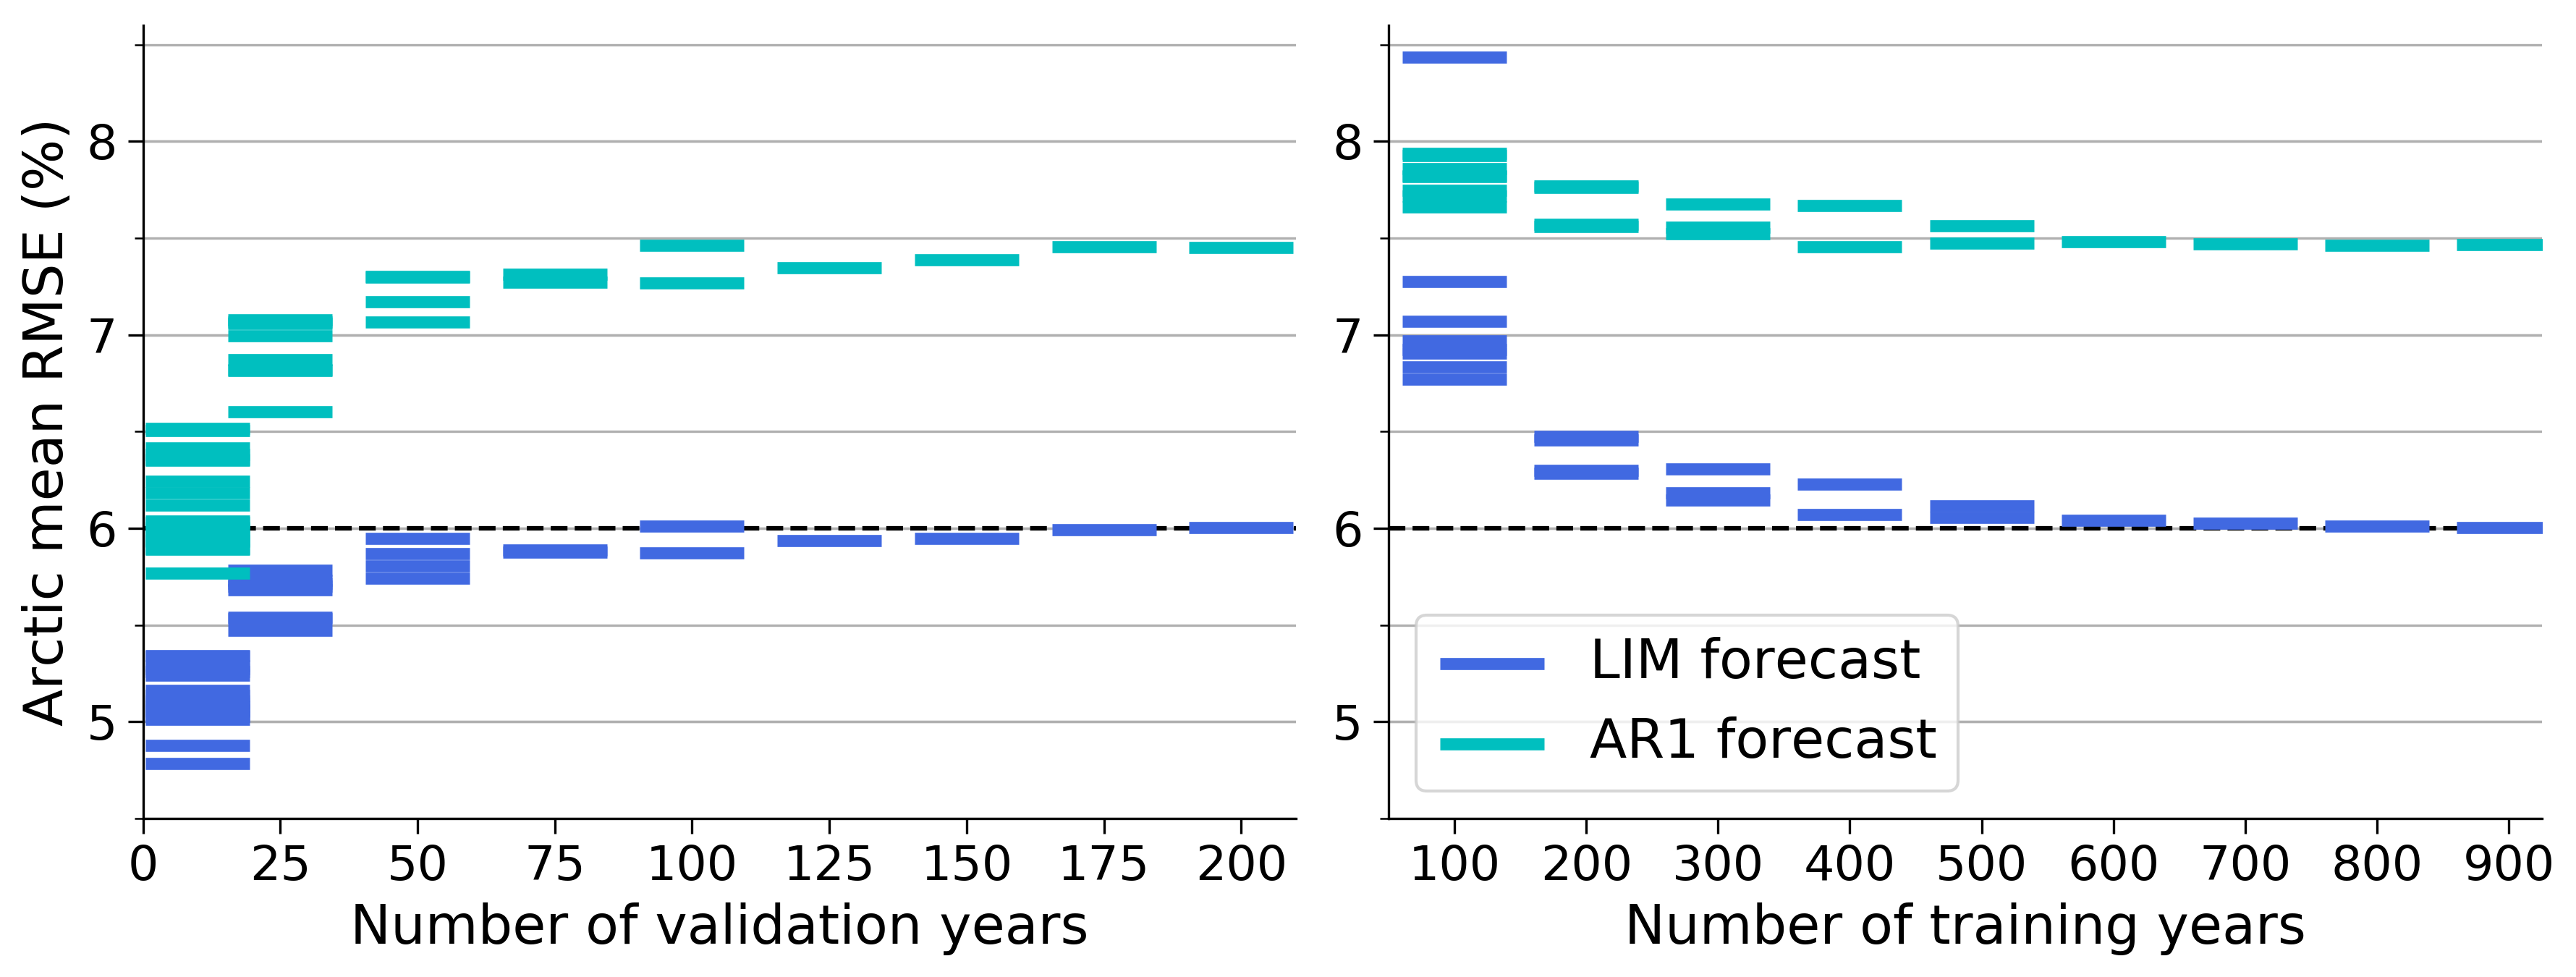

In [19]:
fig,axs = plt.subplots(1,2,figsize=(12,5))
ax = axs.flatten()

nloop = [1,1,1,1,2,2,4,8,20]
nyrs_valid = [200,175,150,125,100,75,50,25,10]

# ax[0].axhline(0.06, color='k', linestyle='--',zorder=5)
# ax[1].axhline(0.06, color='k', linestyle='--',zorder=5)
ax[0].axhline(6, color='k', linestyle='--',zorder=5)
ax[1].axhline(6, color='k', linestyle='--',zorder=5)

for y,yrvalid in enumerate(nyrs_valid):    
    for i in range(nloop[y]):
        if y <1: 
            ax[0].scatter(yrvalid,rmse_all[yrvalid][i,0]*100, linewidth=4, marker='_', s=1200, 
                       color='royalblue', label='LIM forecast',zorder=15)
            ax[0].scatter(yrvalid,ar1_rmse_all[yrvalid][i,0]*100, linewidth=4, marker='_', s=1200, 
                       color='c', label='AR1 forecast',zorder=15)
        else:
            ax[0].scatter(yrvalid,rmse_all[yrvalid][i,0]*100, linewidth=4, marker='_', s=1200, 
                          color='royalblue',zorder=15)
            ax[0].scatter(yrvalid,ar1_rmse_all[yrvalid][i,0]*100, linewidth=4, marker='_', s=1200, 
                          color='c',zorder=15)

for n,yrtrain in enumerate(train_length):
    for l in range(nloop_train[n]):
        if (n==0)&(l<1): 
            ax[1].scatter(yrtrain,ntrain_data['rmse_sic'][yrtrain][l,0]*100, linewidth=4, marker='_', s=1200, 
                       color='royalblue', label='LIM forecast',zorder=15)
            ax[1].scatter(yrtrain,ntrain_data['ar1_rmse_sic'][yrtrain][l,0]*100, linewidth=4, marker='_', s=1200, 
                       color='c', label='AR1 forecast',zorder=15)
        else:
            ax[1].scatter(yrtrain,ntrain_data['rmse_sic'][yrtrain][l,0]*100, linewidth=4, marker='_', s=1200, 
                          color='royalblue',zorder=15)
            ax[1].scatter(yrtrain,ntrain_data['ar1_rmse_sic'][yrtrain][l,0]*100, linewidth=4, marker='_', s=1200, 
                          color='c',zorder=15)

#ax[0].set_ylim(0.045,0.086)
ax[0].set_ylim(4.5,8.6)
ax[0].set_xlim(0,210)
ax[0].set_xlabel('Number of validation years', fontsize=18)
ax[0].tick_params(labelsize=16)
ax[0].set_ylabel('Arctic mean RMSE (%)', fontsize=18)
ax[0].set_xticks(np.arange(0,201,25))
#ax[0].set_yticks(np.arange(4.5,8.6,0.5))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.5))
ax[0].tick_params(which='minor', length=3)
ax[0].tick_params(which='major', length=5)

ax[1].set_xlim(50,925)
#ax[1].set_ylim(0.045,0.086)
ax[1].set_ylim(4.5,8.6)
ax[1].set_xlabel('Number of training years', fontsize=18)
ax[1].tick_params(labelsize=16)
ax[1].legend(loc='lower left', fontsize=18)
#plt.gca().axes.yaxis.set_ticklabels([])
ax[1].set_xticks(np.arange(100,901,100))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.5))
ax[1].tick_params(which='minor', length=3)
ax[1].tick_params(which='major', length=5)

ax[0].grid(axis='y', which='both',zorder=0)
ax[1].grid(axis='y', which='both',zorder=0)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

savename = './figures/nvalid_ntraining_sensitivity_LME_os.png'
plt.savefig(savename)

In [35]:
ntrain_data['rmse_sic'][yrtrain].shape

(1, 8)

## Calculate climotology and use as forecast: 

In [18]:
nloop = [1,1,1,1,2,2,4,8,20]
nyrs_valid = [200,175,150,125,100,75,50,25,10]

import random

In [19]:
nyrtotal = 1155

rand_ints = [random.randint(0, 800) for p in range(yrvalid)]

In [20]:
var = 'sic'

fdic_valid = limkb.build_training_dic('cesm_lme')
fdic_train = limkb.build_training_dic('cesm_lme')
full_names, areawt_name, month_names = limbuild.load_full_names()
    
areacell = {}
areacell_dict = {}
areacell_dict_all = {} 
areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic_train, 
                                                       remove_climo=False, detrend=False, verbose=False, 
                                                       lat_cutoff=40)

Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40


### Load Training data: 

In [21]:
yrsvalid = nyrs_valid[0]
tecut = 1155 - 800
v = {}
validation_stats_lags = {}

X_var, _ = limkb.load_data(var, v, fdic_train, remove_climo=True, detrend=True, 
                           verbose=True,tscut=False, tecut=tecut, lat_cutoff=40)

if var == 'sic':
    if np.nanmax(X_var)>1:
        print('Changing units of sic be a between 0 to 1')
        X_var = X_var/100

Loading from sic
Loading from aIceData/LME/LIMs/sic_SImon_CESM_LME_nh_002_085001-200512.nc
time dimension: 850 - 1650
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...


KeyboardInterrupt: 

In [ ]:
climo_train = np.nanmean(X_var,axis=1)

In [ ]:
np.savez('sic_cesm_lme_climotology_850_1650.npz',climo_train)

### Load validation data: 

In [22]:
data = np.load('sic_cesm_lme_climotology_850_1650.npz')

climo_train = data['arr_0']

In [45]:
lag = 1

# nloop = [1,1,1,1,2,2,4,8,20]
# nyrs_valid = [200,175,150,125,100,75,50,25,10]
nloop = [20]
nyrs_valid = [10]

In [46]:
gm_rmse_all = {}
gsum_rmse_all = {}

for y,yrsvalid in enumerate(nyrs_valid):
    gm_rmse = np.zeros((nloop[y]))
    gsum_rmse = np.zeros((nloop[y]))
    for i in range(nloop[y]):
        startyr = 1651-850
        startyr = startyr+i*yrvalid
        tscut = startyr
        tecut = int(startyr+yrsvalid)
        print('tscut = '+str(tscut))
        print('tecut = '+str(tecut))

        v = {}
        validation_stats_lags = {}

        X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=True, detrend=True, 
                                   verbose=True,tscut=tscut, tecut=tecut, lat_cutoff=40)

        if var == 'sic':
            if np.nanmax(X_var)>1:
                print('Changing units of sic be a between 0 to 1')
                X_var = X_var/100

        units = areacell_dict_all[var][areawt_name[var]]['units']

        if 'km' in units:
            acell = areacell[var]
        elif 'centi' in units: 
            print('changing cellarea units from '+
                  str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
            acell = areacell[var]*(1e-10)
            units = 'km^2'
        else: 
            print('changing cellarea units from '+
                  str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
            acell = areacell[var]*(1e-6)
            units = 'km^2'

        x_truth = X_var[:,lag:]
        truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]

        forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_os['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

        rmse = np.sqrt(np.nanmean((truth_anom-climo_train[:,np.newaxis])**2,axis=1))
        gm_rmse[i] = statskb.global_mean(rmse*forecast_nan_mask,acell)
        gsum_rmse[i] = np.nansum(rmse*forecast_nan_mask)
    
    gm_rmse_all[yrsvalid] = gm_rmse
    gsum_rmse_all[yrvalid] = gsum_rmse_all

tscut = 801
tecut = 811
Loading from sic
Loading from aIceData/LME/LIMs/sic_SImon_CESM_LME_nh_002_085001-200512.nc
time dimension: 1651 - 1660
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in sate

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with zeros...
Working on month...10
Found with nans (not in satellite), going to fill with zeros...
Working on month...11
Found with nans (not in satellite), going to fill with zeros...
-----------------------------------------------------
completed

Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with zeros...
Working on month...10
Found with nans (not in satellite), going to fill with zeros...
Working on month...11
Found with nans (not in satellite), going to fill with zeros...
-----------------------------------------------------
completed

Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with zeros...
Working on month...10
Found with nans (not in satellite), going to fill with zeros...
Working on month...11
Found with nans (not in satellite), going to fill with zeros...
-----------------------------------------------------
completed

Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with zeros...
Working on month...10
Found with nans (not in satellite), going to fill with zeros...
Working on month...11
Found with nans (not in satellite), going to fill with zeros...
-----------------------------------------------------
completed

In [48]:
gm_rmse_all[10]

array([0.06123914, 0.06099937, 0.06706327, 0.06914385, 0.06496777,
       0.06629402, 0.06813432, 0.0627924 , 0.06358964, 0.06114984,
       0.06237844, 0.06314927, 0.06166357, 0.06673535, 0.0595838 ,
       0.06591361, 0.06565736, 0.06154382, 0.06215708, 0.06105993])

In [49]:
#gm_rmse_all_full= gm_rmse_all
gm_rmse_all_full[10] = gm_rmse_all[10]

In [50]:
gm_rmse_all_full

{50: array([0.07583933, 0.07462949, 0.07711126, 0.07740269]),
 25: array([0.07168636, 0.07452264, 0.07436348, 0.07497737, 0.07974363,
        0.07312862, 0.07079636, 0.05268953]),
 200: array([0.07899734]),
 175: array([0.07907604]),
 150: array([0.07822048]),
 125: array([0.07774525]),
 100: array([0.07692844, 0.08129761]),
 75: array([0.07742224, 0.07992403]),
 10: array([0.06123914, 0.06099937, 0.06706327, 0.06914385, 0.06496777,
        0.06629402, 0.06813432, 0.0627924 , 0.06358964, 0.06114984,
        0.06237844, 0.06314927, 0.06166357, 0.06673535, 0.0595838 ,
        0.06591361, 0.06565736, 0.06154382, 0.06215708, 0.06105993])}

In [32]:
gm_rmse_all[200] = np.array([0.07899734])
gm_rmse_all[175] = np.array([0.07907604])
gm_rmse_all[150] = np.array([0.07822048])
gm_rmse_all[125] = np.array([0.07774525])
gm_rmse_all[100] = np.array([0.07692844, 0.08129761])
gm_rmse_all[75] = np.array([0.07742224, 0.07992403])

In [51]:
savename = 'sic_cesm_lme_climotology_ntraining_years.pkl'
pickle.dump(gm_rmse_all_full, open(savename, "wb" ) )

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(16,6))
ax = axs.flatten()

for i,lag in enumerate(lags):
    ax[0].plot(rmse_sic_is[:,i], label='lag '+str(lag), linewidth=4,color=colors[i])
    ax[1].plot(rmse_sic_os[:,i], label='lag '+str(lag), linewidth=4,color=colors[i])
    
ax[0].set_xlim(0,8)
#ax[0].set_ylim(0.059,0.09)
#ax[0].legend(bbox_to_anchor=[1,1],fontsize=14)
ax[0].set_ylabel('GM RMSE', fontsize=16)
ax[0].set_xlabel('Number of validation years', fontsize=16)
ax[0].set_xticklabels(nyrs_valid, fontsize=14)
ax[0].set_title('In Sample Validation', fontsize=18)
ax[0].tick_params(labelsize=14)


ax[1].set_xlim(0,8)
#ax[1].set_ylim(0.059,0.09)
ax[1].legend(bbox_to_anchor=[1,1],fontsize=14)
ax[1].set_ylabel('GM RMSE', fontsize=16)
ax[1].set_xlabel('Number of validation years', fontsize=16)
ax[1].set_xticklabels(nyrs_valid, fontsize=14)
ax[1].set_title('Out of Sample Validation', fontsize=18)
ax[1].tick_params(labelsize=14)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

for i,lag in enumerate(lags):
    plt.plot(rmse_sic_os[:,i], label='lag '+str(lag), linewidth=4,color=colors[i])
    
plt.xlim(0,8)
plt.legend(bbox_to_anchor=[0.8,0.6],fontsize=14)
plt.ylabel('GM RMSE', fontsize=16)
plt.xlabel('Number of validation years', fontsize=16)
ax.set_xticklabels(nyrs_valid, fontsize=14)
plt.yticks(fontsize=14)

plt.title('Out of Sample Validation', fontsize=18)

In [ ]:
nyrs_valid

In [ ]:
for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]

    #folder = 'reanalysis/'
    #filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2020_sic'+str(ntrunc_sic)+
    #             '_'+date_of_interest+'.pkl')
    folder='historical/'
    filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tas'+str(ntrunc_sic)+
                '_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')

    experiment =  pickle.load(open(folder+filename, 'rb'))
    
    exp_setup = experiment['forecast']['exp_setup']
    forecast = experiment['forecast']
    LIMd = experiment['LIMd']
    forecast_validation = experiment['forecast_validation']
    forecast_validation_lags = experiment['forecast_validation_lags']
    ar1cast = experiment['ar1cast']
    ar1cast_lags = experiment['ar1cast_lags']
    
    [tcmip, vcmip, valid_yrs_str, texp, 
     vexp, tmod, vmod, wt_addin, tr_addin] = get_title_strings(var,exp_setup,forecast)
    
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------
    
    fig,axs = plt.subplots(1,2,figsize=(20,6))
    
    ax = axs.flatten()

    
    plot_lagged_performance_1var(fig,ax[0],'sic',forecast_validation_lags,ar1cast_lags,
                                 tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                 wt_addin, tr_addin)
    plot_monthly_performance_1var(fig,ax[1],'sic',forecast_validation_lags,ar1cast_lags,
                                  tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                  wt_addin, tr_addin)
    

    if exp_setup['Insamp']==True:     
        plt.suptitle(('LIM trained on all months: Neofs = '+str(ntrunc)+'\n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                     ', Validation years: Historical'), fontsize=16)
    else: 
        plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+': Neofs = '+str(ntrunc)+'\n Training years: '+
                      tcmip+' '+tmod+' '+texp+' '+exp_setup['mod_sic_filename'][-22:-13]+', \nValidation years: '+
                      vcmip+' '+vmod+' '+vexp+' '+valid_yrs_str), fontsize=16)

    ax[0].legend(loc='upper right', fontsize=14)
    ax[0].set_xlabel('Lag (months)', fontsize=14)
    
    ax[1].legend(loc='lower right', fontsize=14)
    ax[1].set_xlabel('Lag (months)', fontsize=14)
    ax[1].set_ylabel('Global mean RMSE', fontsize=14)

    plt.subplots_adjust(top=0.85)

In [ ]:
ar1cast_lags['validation_stats_ar1_lags'][var]['gm_rmse'][:-1]

In [ ]:
ar1cast_lags['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1],

In [ ]:
ntrunc_list = [5,10,15,20,25,30,35,40,60,70,80,90,100] # EOF truncation for individual fields (reduced-state space)
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic_list = [5,10,15,20,25,30,35,40,60,70,80,90,100]
#modes_sic = 20

mo='all'
#mo=0

#model = 'satellite'
#model = 'cmip6_mpi_hist'
#model = 'era5'
model = 'cesm_lme'
#date_of_interest = '20211019'
#date_of_interest = '20211027'
date_of_interest = '20211113'
#date_of_interest = '20211015'

end_trainyr = '1650'

# forecast lead time in months that defines the LIM training
tau = 1

# variables to include in the LIM (note "vars" is a Python command)
limvars = ['tas','psl','tos','sit','sic']
#limvars = ['sic']

data_dir = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/'

In [ ]:
#colors = ['royalblue','purple', 'c', 'orange', 'green','navy','sienna','grey','k']

cmap = matplotlib.cm.get_cmap('plasma')

move = 1/len(nmodes_sic_list)
colors = [cmap(i) for i in np.arange(0.0,1.1,move)]

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(18,10))
ax = axs.flatten()

ax[0].axhline(0.0, color='gray', linewidth=3, label='AR1 Forecast')
ax[1].axhline(0.0, color='gray', linewidth=3, label='AR1 Forecast')
ax[2].axhline(0.0, color='gray', linewidth=3, label='AR1 Forecast')

for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]
    
    var_names = (str(ntrunc)+"_").join(limvars)+str(ntrunc_sic)

#     folder = 'historical/'
#     filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tos'+str(ntrunc_sic)+
#                 '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
#     filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_tos'+str(ntrunc_sic)+
#                 '_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
#     filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_sic'+str(ntrunc_sic)+
#               '_'+date_of_interest+'.pkl')

#     folder = 'satellite/'
#     filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_2004_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    
#     folder = 'reanalysis/'
#     if n<2:
#         filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2020_sic'+str(ntrunc_sic)+
#                     '_'+date_of_interest+'.pkl')
#     else: 
#         filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
# #     filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_sic'+str(ntrunc_sic)+
# #                 '_'+date_of_interest+'.pkl')

    folder = 'last_millennium/'
#     filename = ('Validation_'+model+'_ntrain_851_'+end_trainyr+'_validyrs_1351_1361_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    filename = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_1651_1850_'+var_names+
                '_'+date_of_interest+'.pkl')

    print('Loading '+data_dir+folder+filename)

    experiment =  pickle.load(open(data_dir+folder+filename, 'rb'))
    
    exp_setup = experiment['forecast']['exp_setup']
    forecast = experiment['forecast']
    forecast_validation_lags = experiment['forecast_validation_lags']
    ar1cast_lags = experiment['ar1cast_lags']
    
    [tcmip, vcmip, valid_yrs_str, texp, 
     vexp, tmod, vmod, wt_addin, tr_addin] = get_title_strings(var,exp_setup,forecast)
    
    ar1_corr = ar1cast_lags['validation_stats_ar1_lags']['sic']['corr_tot'][:-1]
    ar1_ce = ar1cast_lags['validation_stats_ar1_lags']['sic']['ce_tot'][:-1]
    ar1_gm_rmse = ar1cast_lags['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]

    corr_diff = forecast_validation_lags['validation_stats_lags']['sic']['corr_tot'][1:] - ar1_corr
    ce_diff = forecast_validation_lags['validation_stats_lags']['sic']['ce_tot'][1:] - ar1_ce
    rmse_diff = ar1_gm_rmse - forecast_validation_lags['validation_stats_lags']['sic']['gm_rmse'][1:]
    
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------

    ax[0].plot(exp_setup['lags'][1:],corr_diff,label=('neofs = '+str(ntrunc)),linewidth=4.0, color=colors[n])
    ax[2].plot(exp_setup['lags'][1:],ce_diff,label=('neofs = '+str(ntrunc)),linewidth=4.0, color=colors[n])
    ax[1].plot(exp_setup['lags'][1:],rmse_diff,label=('neofs = '+str(ntrunc)),linewidth=4.0, color=colors[n])
    

ax[1].set_xticklabels(np.arange(1,18,1),fontsize=14)
#ax[1].set_yticklabels(np.arange(-0.00041,0.00041,0.0002),fontsize=14)
#ax[1].set_ylim(-0.0001,0.003)
#ax[1].set_ylim(-0.00005,0.00005)
ax[1].set_xlim(1,8)
ax[1].grid(axis='both')

# ax[0].set_xticks(np.arange(0,8,1))
ax[0].set_xticklabels(np.arange(1,18,1),fontsize=14)
#ax[0].set_yticklabels(np.arange(-0.21,0.21,0.1),fontsize=14)
#ax[0].set_ylim(-0.5,0.5)
#ax[0].set_ylim(-0.25,0.25)
ax[0].set_xlim(1,8)
ax[0].grid(axis='both')

ax[2].set_xticklabels(np.arange(1,18,1),fontsize=14)
#ax[2].set_yticklabels(np.arange(-0.21,0.21,0.1),fontsize=14)
#ax[2].set_ylim(-0.5,0.5)
#ax[2].set_ylim(-0.25,0.25)
ax[2].set_xlim(1,8)
ax[2].grid(axis='both')

# ax[3].xaxis.set_visible(False) 
# ax[3].yaxis.set_visible(False)
ax[3].axis('off')
    
if exp_setup['Insamp']==True:     
    plt.suptitle(('LIM trained on all months:\n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else: 
    plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+': \n Training years: '+
                  tcmip+' '+tmod+' '+texp+' '+exp_setup['mod_sic_filename'][-22:-13]+', \nValidation years: '+
                  vcmip+' '+vmod+' '+vexp+' '+valid_yrs_str), fontsize=16)

#ax[0].legend(loc='upper right', fontsize=14)
ax[0].set_xlabel('Lag (months)', fontsize=16)
ax[0].set_ylabel('Change in Correlation', fontsize=16)

ax[2].set_xlabel('Lag (months)', fontsize=16)
ax[2].set_ylabel('Change in CE', fontsize=16)

#ax[3].legend(loc='upper left', fontsize=14)
ax[2].legend(bbox_to_anchor=(0.7,0,1,1), fontsize=16)
ax[1].set_xlabel('Lag (months)', fontsize=16)
ax[1].set_ylabel('Change in Global mean RMSE', fontsize=16)

plt.subplots_adjust(top=0.90)

In [ ]:
cmap = matplotlib.cm.get_cmap('viridis')

move = 1/3
colors_lags = [cmap(i) for i in np.arange(0.0,1.1,move)]

fig,axs = plt.subplots(2,1,figsize=(9,10))
ax = axs.flatten()

rmse_ar1_tot_is = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))
rmse_ar1_tot_os = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))

rmse_tot_is = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))
rmse_tot_os = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))

for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]
    
    var_names = (str(ntrunc)+"_").join(limvars)+str(ntrunc_sic)

#    folder = 'historical/'
#     filename_os = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     if n <2:
#         filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_sic'+str(ntrunc_sic)+
#                   '_'+date_of_interest+'.pkl')
#     else:
#         filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_sic'+str(ntrunc_sic)+
#                       '_'+date_of_interest+'.pkl')
#     filename_os =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tos'+str(ntrunc_sic)+
#                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     if n<2:
# #         filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_tos'+str(ntrunc_sic)+
# #                         '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     else: 
#     filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_tos'+str(ntrunc_sic)+
#                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')

#     folder = 'satellite/'
#     filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_2004_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    
#     folder = 'reanalysis/'
#     filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    
    folder = 'last_millennium/'
#     filename_os = ('Validation_'+model+'_ntrain_851_'+end_trainyr+'_validyrs_1351_1361_sic'+
#                    str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_851_'+end_trainyr+'_validyrs_0852_0862_sic'+
#                    str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
    
    filename_os = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_1651_1850_'+var_names+
                   '_'+date_of_interest+'.pkl')
    filename_is = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_0851_1050_'+var_names+
                   '_'+date_of_interest+'.pkl')

    print('Loading '+data_dir+folder+filename_os+ ' \n    and '+folder+filename_is)
    

    experiment_os =  pickle.load(open(data_dir+folder+filename_os, 'rb'))
    experiment_is =  pickle.load(open(data_dir+folder+filename_is, 'rb'))
    
    LIMd_is = experiment_is['LIMd']
    exp_setup_is = experiment_is['forecast']['exp_setup']
    forecast_is = experiment_is['forecast']
    forecast_validation_lags_is = experiment_is['forecast_validation_lags']
    ar1cast_lags_is = experiment_is['ar1cast_lags']
    
    exp_setup_os = experiment_os['forecast']['exp_setup']
    forecast_os = experiment_os['forecast']
    forecast_validation_lags_os = experiment_os['forecast_validation_lags']
    ar1cast_lags_os = experiment_os['ar1cast_lags']
    
    [tcmip_is, vcmip_is, valid_yrs_str_is, texp_is, 
     vexp_is, tmod_is, vmod_is, wt_addin_is, tr_addin_is] = get_title_strings(var,exp_setup_is,forecast_is)
    [tcmip_os, vcmip_os, valid_yrs_str_os, texp_os, 
     vexp_os, tmod_os, vmod_os, wt_addin_os, tr_addin_os] = get_title_strings(var,exp_setup_os,forecast_os)
    
    ar1_gm_rmse_is = ar1cast_lags_is['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    ar1_gm_rmse_os = ar1cast_lags_os['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    
    rmse_ar1_tot_is[n,:] = ar1cast_lags_is['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    rmse_ar1_tot_os[n,:] = ar1cast_lags_os['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    
    rmse_tot_is[n,:] = forecast_validation_lags_is['validation_stats_lags']['sic']['gm_rmse'][1:]
    rmse_tot_os[n,:] = forecast_validation_lags_os['validation_stats_lags']['sic']['gm_rmse'][1:]

    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------

for i in np.arange(1,4,1):
    ax[0].plot(np.array(ntrunc_list),rmse_tot_is[:,i],
               label=('lag = '+str(i)),linewidth=4.0, color=colors_lags[i-1])
    ax[0].plot(np.array(ntrunc_list),rmse_ar1_tot_is[:,i],
               label=('AR1'),linewidth=4.0, linestyle='--',color=colors_lags[i-1])
    ax[1].plot(np.array(ntrunc_list),rmse_ar1_tot_os[:,i],
               label=('AR1'),linewidth=4.0,linestyle='--',color=colors_lags[i-1]) 
    ax[1].plot(np.array(ntrunc_list),rmse_tot_os[:,i],
               label=('lag = '+str(i)),linewidth=4.0, color=colors_lags[i-1])  

ax[0].set_xticks(np.arange(25,251,25))
#ax[0].set_xticklabels(fontsize=14)
ax[0].set_xlim(5,250)
ax[0].set_ylim(0.06,0.085)
ax[0].grid(axis='both')

ax[1].set_xticks(np.arange(25,251,25))
#ax[1].set_xticklabels(fontsize=14)
ax[1].set_xlim(5,250)
ax[1].set_ylim(0.06,0.085)
ax[1].grid(axis='both')


title_is = ('Validation years: '+vcmip_is+' '+vmod_is+' '+vexp_is+' '+valid_yrs_str_is)
title_os = ('Validation years: '+vcmip_os+' '+vmod_os+' '+vexp_os+' '+valid_yrs_str_os)

ax[0].set_title(title_is, fontsize=14)
ax[1].set_title(title_os, fontsize=14)
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip_is+' '+tmod_is+' '+texp_is+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)

#ax[0].legend(loc='upper right', fontsize=14)
#ax[0].set_xlabel('Lag (months)', fontsize=16)
ax[0].set_ylabel('Global mean RMSE', fontsize=16)

ax[1].set_xlabel('Number of EOFs retained', fontsize=16)
ax[1].set_ylabel('Global mean RMSE', fontsize=16)

ax[1].legend(bbox_to_anchor=(0.6,0,0.7,1), fontsize=16)

plt.subplots_adjust(top=0.85)

In [ ]:
cmap = matplotlib.cm.get_cmap('viridis')

move = 1/3
colors_lags = [cmap(i) for i in np.arange(0.0,1.1,move)]

fig,axs = plt.subplots(1,1,figsize=(9,5))

for i in np.arange(1,4,1):
    plt.plot(np.array(ntrunc_list),rmse_tot_is[:,i],
               label=('lag = '+str(i)+' (in sample)'),linewidth=4.0, color=colors_lags[i-1])
    plt.plot(np.array(ntrunc_list),rmse_tot_os[:,i],linestyle='--',
               label=('lag = '+str(i)+' (out of sample)'),linewidth=4.0, color=colors_lags[i-1])  

plt.xticks(np.arange(25,251,25))
plt.xlim(5,250)
plt.ylim(0.06,0.085)
plt.grid(axis='both')

title_is = ('Validation years: '+vcmip_is+' '+vmod_is+' '+vexp_is+' '+valid_yrs_str_is)
title_os = ('Validation years: '+vcmip_os+' '+vmod_os+' '+vexp_os+' '+valid_yrs_str_os)
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip_is+' '+tmod_is+' '+texp_is+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)

plt.ylabel('Global mean RMSE', fontsize=16)
plt.xlabel('Number of EOFs retained', fontsize=16)

plt.legend(bbox_to_anchor=(0.85,0,0.7,1), fontsize=16)

# plt.subplots_adjust(top=0.75)

In [ ]:
rmse_tot_is

In [ ]:
nmodes_sic_list [9]

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(18,10))
ax = axs.flatten()

ax[0].axhline(0.0, color='gray', linewidth=3, label='AR1 Forecast')
ax[2].axhline(0.0, color='gray', linewidth=3,label='AR1 Forecast')
ax[1].axhline(0.0, color='gray', linewidth=3,label='AR1 Forecast')

rmse_tot_is = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))
rmse_tot_os = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))

rmse_diff_tot_is = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))
rmse_diff_tot_os = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))

for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]
    
    var_names = (str(ntrunc)+"_").join(limvars)+str(ntrunc_sic)

#    folder = 'historical/'
#     filename_os = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     if n <2:
#         filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_sic'+str(ntrunc_sic)+
#                   '_'+date_of_interest+'.pkl')
#     else:
#         filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_sic'+str(ntrunc_sic)+
#                       '_'+date_of_interest+'.pkl')
#     filename_os =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tos'+str(ntrunc_sic)+
#                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     if n<2:
# #         filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_tos'+str(ntrunc_sic)+
# #                         '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     else: 
#     filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_tos'+str(ntrunc_sic)+
#                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')

#     folder = 'satellite/'
#     filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_2004_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    
#     folder = 'reanalysis/'
#     filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    
    folder = 'last_millennium/'
#     filename_os = ('Validation_'+model+'_ntrain_851_'+end_trainyr+'_validyrs_1351_1361_sic'+
#                    str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_851_'+end_trainyr+'_validyrs_0852_0862_sic'+
#                    str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
    
    filename_os = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_1651_1850_'+var_names+
                   '_'+date_of_interest+'.pkl')
    filename_is = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_0851_1050_'+var_names+
                   '_'+date_of_interest+'.pkl')

    print('Loading '+data_dir+folder+filename_os+ ' \n    and '+folder+filename_is)
    

    experiment_os =  pickle.load(open(data_dir+folder+filename_os, 'rb'))
    experiment_is =  pickle.load(open(data_dir+folder+filename_is, 'rb'))
    
    LIMd_is = experiment_is['LIMd']
    exp_setup_is = experiment_is['forecast']['exp_setup']
    forecast_is = experiment_is['forecast']
    forecast_validation_lags_is = experiment_is['forecast_validation_lags']
    ar1cast_lags_is = experiment_is['ar1cast_lags']
    
    exp_setup_os = experiment_os['forecast']['exp_setup']
    forecast_os = experiment_os['forecast']
    forecast_validation_lags_os = experiment_os['forecast_validation_lags']
    ar1cast_lags_os = experiment_os['ar1cast_lags']
    
    [tcmip_is, vcmip_is, valid_yrs_str_is, texp_is, 
     vexp_is, tmod_is, vmod_is, wt_addin_is, tr_addin_is] = get_title_strings(var,exp_setup_is,forecast_is)
    [tcmip_os, vcmip_os, valid_yrs_str_os, texp_os, 
     vexp_os, tmod_os, vmod_os, wt_addin_os, tr_addin_os] = get_title_strings(var,exp_setup_os,forecast_os)
    
    ar1_gm_rmse_is = ar1cast_lags_is['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    ar1_gm_rmse_os = ar1cast_lags_os['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]

    rmse_diff_is = ar1_gm_rmse_is - forecast_validation_lags_is['validation_stats_lags']['sic']['gm_rmse'][1:]
    rmse_diff_os = ar1_gm_rmse_os - forecast_validation_lags_os['validation_stats_lags']['sic']['gm_rmse'][1:]
    
    rmse_diff_tot_is[n,:] = rmse_diff_is
    rmse_diff_tot_os[n,:] = rmse_diff_os
    rmse_tot_is[n,:] = forecast_validation_lags_is['validation_stats_lags']['sic']['gm_rmse'][1:]
    rmse_tot_os[n,:] = forecast_validation_lags_os['validation_stats_lags']['sic']['gm_rmse'][1:]
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------

    ax[1].plot(-1/(LIMd_is['lam_L']),linewidth=4.0, color=colors[n])
    ax[0].plot(exp_setup_is['lags'][1:],rmse_diff_is,label=('neofs = '+str(ntrunc)),
               linewidth=4.0, color=colors[n])
    ax[2].plot(exp_setup_os['lags'][1:],rmse_diff_os,label=('neofs = '+str(ntrunc)),
               linewidth=4.0, color=colors[n])
    

for i,m in enumerate(np.argmin(rmse_tot_is,axis=0)):
    ax[0].scatter(exp_setup_is['lags'][1:][i],0.011,#(np.round(np.max(rmse_diff_tot_is),4)+0.0001),
                  color=colors[m], s=100)  
for i,m in enumerate(np.argmin(rmse_tot_os,axis=0)):
    ax[2].scatter(exp_setup_os['lags'][1:][i],0.0085,#(np.round(np.max(rmse_diff_tot_os),4)+0.0001),
                  color=colors[m],s=100)   
    
ax[0].set_xticklabels(np.arange(1,18,1),fontsize=14)
ax[0].set_xlim(1,8)
ax[0].set_ylim(-0.0015,0.012)
ax[0].grid(axis='both')

ax[2].set_xticklabels(np.arange(1,18,1),fontsize=14)
ax[2].set_xlim(1,8)
ax[2].set_ylim(-0.0015,0.009)
ax[2].grid(axis='both')

ax[1].grid(axis='both')
ax[1].set_ylim(-1,25)

ax[3].axis('off')

title_is = ('Validation years: '+vcmip_is+' '+vmod_is+' '+vexp_is+' '+valid_yrs_str_is)
title_os = ('Validation years: '+vcmip_os+' '+vmod_os+' '+vexp_os+' '+valid_yrs_str_os)

ax[0].set_title(title_is, fontsize=14)
ax[2].set_title(title_os, fontsize=14)
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip_is+' '+tmod_is+' '+texp_is+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)

#ax[0].legend(loc='upper right', fontsize=14)
#ax[0].set_xlabel('Lag (months)', fontsize=16)
ax[0].set_ylabel('Change in Global mean RMSE', fontsize=16)

ax[1].set_xlabel('Eigenvalue of L', fontsize=16)
ax[1].set_ylabel('EFT (months)', fontsize=16)

ax[2].set_xlabel('Lag (months)', fontsize=16)
ax[2].set_ylabel('Change in Global mean RMSE', fontsize=16)

ax[2].legend(bbox_to_anchor=(0.7,0,1,1), fontsize=16)

plt.subplots_adjust(top=0.85)

In [ ]:
exp_setup_os['lags'][1:]

## Results relative to 'sic' only: 

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(18,10))
ax = axs.flatten()

ax[0].axhline(0.0, color='gray', linewidth=3, label='Sic only forecast')
ax[2].axhline(0.0, color='gray', linewidth=3, label='Sic only forecast')
ax[1].axhline(0.0, color='gray', linewidth=3, label='Sic only forecast')

rmse_sic_is = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))
rmse_sic_os = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))

rmse_diff_sic_is = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))
rmse_diff_sic_os = np.zeros((len(ntrunc_list),len(exp_setup['lags'][1:])))

for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]

    var_names = (str(ntrunc)+"_").join(limvars)+str(ntrunc_sic)
    
#     folder = 'historical/'
# #     filename_os = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_sic'+str(ntrunc_sic)+
# #                 '_'+date_of_interest+'.pkl')
# #     filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_sic'+str(ntrunc_sic)+
# #               '_'+date_of_interest+'.pkl')
#     filename_os =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tos'+str(ntrunc_sic)+
#                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     if n<2:
# #         filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_tos'+str(ntrunc_sic)+
# #                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     else: 
#     filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_tos'+str(ntrunc_sic)+
#                 '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
    
#     filename_sic_os =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tos'+str(ntrunc_sic)+
#                     '_sic'+str(ntrunc_sic) +'_20211102.pkl')
# #     if n<2:
# #          filename_sic_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_sic'+str(ntrunc_sic)
# #                         +'_20211102.pkl')
# #     else:
#     filename_sic_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_sic'+str(ntrunc_sic)
#                         +'_20211102.pkl')

#     folder = 'satellite/'
#     filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_2004_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    
#     folder = 'reanalysis/'
#     filename_sic_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_tos'+str(ntrunc_sic)+
#                        '_sic'+str(ntrunc_sic)+
#                       '_'+date_of_interest+'.pkl')
#     filename_sic_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_tos'+str(ntrunc_sic)+
#                        '_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')

#     filename_sic_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                       '_'+date_of_interest+'.pkl')
#     filename_sic_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_sic'+str(ntrunc_sic)+
#                       '_'+date_of_interest+'.pkl')

    folder = 'last_millennium/'
    filename_os = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_1651_1850_'+var_names+
                   '_'+date_of_interest+'.pkl')
    filename_is = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_0851_1050_'+var_names+
                   '_'+date_of_interest+'.pkl')

    filename_sic_os = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_1651_1850_sic'+str(ntrunc_sic)+
                      '_'+date_of_interest+'.pkl')
    filename_sic_is = ('LIMcast_'+model+'_002_ntrain_850_'+end_trainyr+'_validyrs_0851_1050_sic'+str(ntrunc_sic)+
                      '_'+date_of_interest+'.pkl')

    print('Loading '+data_dir+folder+filename_os+ ' \n    and '+folder+filename_is)
    

    experiment_os =  pickle.load(open(data_dir+folder+filename_os, 'rb'))
    experiment_is =  pickle.load(open(data_dir+folder+filename_is, 'rb'))
    
    experiment_sic_os =  pickle.load(open(data_dir+folder+filename_sic_os, 'rb'))
    experiment_sic_is =  pickle.load(open(data_dir+folder+filename_sic_is, 'rb'))
    
    LIMd_is = experiment_is['LIMd']
    exp_setup_is = experiment_is['forecast']['exp_setup']
    forecast_is = experiment_is['forecast']
    forecast_validation_lags_is = experiment_is['forecast_validation_lags']
    ar1cast_lags_is = experiment_is['ar1cast_lags']
    
    exp_setup_os = experiment_os['forecast']['exp_setup']
    forecast_os = experiment_os['forecast']
    forecast_validation_lags_os = experiment_os['forecast_validation_lags']
    ar1cast_lags_os = experiment_os['ar1cast_lags']
    
    exp_setup_sic_is = experiment_sic_is['forecast']['exp_setup']
    forecast_sic_is = experiment_sic_is['forecast']
    forecast_validation_lags_sic_is = experiment_sic_is['forecast_validation_lags']
    ar1cast_lags_sic_is = experiment_sic_is['ar1cast_lags']
    
    exp_setup_sic_os = experiment_sic_os['forecast']['exp_setup']
    forecast_sic_os = experiment_sic_os['forecast']
    forecast_validation_lags_sic_os = experiment_sic_os['forecast_validation_lags']
    ar1cast_lags_sic_os = experiment_sic_os['ar1cast_lags']
    
    [tcmip_is, vcmip_is, valid_yrs_str_is, texp_is, 
     vexp_is, tmod_is, vmod_is, wt_addin_is, tr_addin_is] = get_title_strings(var,exp_setup_is,forecast_is)
    [tcmip_os, vcmip_os, valid_yrs_str_os, texp_os, 
     vexp_os, tmod_os, vmod_os, wt_addin_os, tr_addin_os] = get_title_strings(var,exp_setup_os,forecast_os)
    
    sic_only_rmse_is = forecast_validation_lags_sic_is['validation_stats_lags']['sic']['gm_rmse'][1:]
    sic_only_rmse_os = forecast_validation_lags_sic_os['validation_stats_lags']['sic']['gm_rmse'][1:]

    rmse_diff_is = sic_only_rmse_is - forecast_validation_lags_is['validation_stats_lags']['sic']['gm_rmse'][1:]
    rmse_diff_os = sic_only_rmse_os - forecast_validation_lags_os['validation_stats_lags']['sic']['gm_rmse'][1:]
    
    rmse_diff_sic_is[n,:] = rmse_diff_is
    rmse_diff_sic_os[n,:] = rmse_diff_os
    rmse_sic_is[n,:] = sic_only_rmse_is
    rmse_sic_os[n,:] = sic_only_rmse_os
    
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------

    ax[1].plot(-1/(LIMd_is['lam_L']),linewidth=4.0, color=colors[n])
    ax[0].plot(exp_setup_is['lags'][1:],rmse_diff_is,label=('neofs = '+str(ntrunc)),
               linewidth=4.0, color=colors[n])
    ax[2].plot(exp_setup_os['lags'][1:],rmse_diff_os,label=('neofs = '+str(ntrunc)),
               linewidth=4.0, color=colors[n])
    
for i,m in enumerate(np.argmin(rmse_sic_is,axis=0)):
    ax[0].scatter(exp_setup_is['lags'][1:][i],0.0058,#(np.round(np.max(rmse_diff_sic_is),3)+0.0001),
                  color=colors[m], s=100)  
for i,m in enumerate(np.argmin(rmse_sic_os,axis=0)):
    ax[2].scatter(exp_setup_os['lags'][1:][i],0.0058,#(np.round(np.max(rmse_diff_sic_os),3)+0.0001),
                  color=colors[m],s=100) 
    
ax[0].set_xticklabels(np.arange(1,18,1),fontsize=14)
ax[0].set_xlim(1,8)
ax[0].set_ylim(-0.0001,0.006)
ax[0].grid(axis='both')

ax[2].set_xticklabels(np.arange(1,18,1),fontsize=14)
ax[2].set_xlim(1,8)
ax[2].set_ylim(-0.0001,0.006)
ax[2].grid(axis='both')

ax[1].grid(axis='both')
#ax[1].set_ylim(-5,40)

ax[3].axis('off')

title_is = ('Validation years: '+vcmip_is+' '+vmod_is+' '+vexp_is+' '+valid_yrs_str_is)
title_os = ('Validation years: '+vcmip_os+' '+vmod_os+' '+vexp_os+' '+valid_yrs_str_os)

ax[0].set_title(title_is, fontsize=14)
ax[2].set_title(title_os, fontsize=14)
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip+' '+tmod+' '+texp+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)

#ax[0].legend(loc='upper right', fontsize=14)
#ax[0].set_xlabel('Lag (months)', fontsize=16)
ax[0].set_ylabel('Change in Global mean RMSE', fontsize=16)

ax[1].set_xlabel('Eigenvalue of L', fontsize=16)
ax[1].set_ylabel('EFT (months)', fontsize=16)

ax[2].set_xlabel('Lag (months)', fontsize=16)
ax[2].set_ylabel('Change in Global mean RMSE', fontsize=16)

ax[2].legend(bbox_to_anchor=(0.7,0,1,1), fontsize=16)

plt.subplots_adjust(top=0.85)

In [ ]:
plt.pcolormesh(rmse_sic_os)
plt.colorbar()

In [ ]:
rmse_sic_os[:,0:3]

## Spatial Performance: 

In [ ]:
def load_validation_data(var, exp_setup, remove_climo=True, detrend=True, verbose=True):
    ## LOad Truth data: 
    fdic_valid = limkb.build_training_dic(exp_setup['valid_dsource'])
    v = {}
    tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])
    #        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
    if tecut <=0: 
        tecut = False
    print('tecut = '+str(tecut) +', tscut = '+str(exp_setup['nyears_startvalid']/12))

    X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=remove_climo, detrend=detrend, 
                               verbose=verbose,tscut=int(exp_setup['nyears_startvalid']/12), 
                               tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'])

    if var is 'sic':
        if np.nanmax(X_var)>1:
            print('Changing units of sic be a between 0 to 1')
            X_var = X_var/100
    
    return X_var

In [ ]:
def calc_validation_stats_spatial(lag_int,var,X_var,exp_setup,forecast,LIMd):
    ## Calculate validation statistics: 
    [truth_anom, 
     forecast_anom] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup['mo'],X_var,
                                                            forecast['x_forecast_dcomp'],
                                                            LIMd_is['var_dict'],insamp=exp_setup['Insamp'])


    print('Truth_anom shape: '+str(truth_anom.shape))
    print('Forecast_anom shape: '+str(forecast_anom.shape))

    corr=np.zeros(truth_anom.shape[0])
    ce=np.zeros(truth_anom.shape[0])

    for i in range(truth_anom.shape[0]):
        corr[i] = np.corrcoef(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))[0,1]
        ce[i] = LMR_utils.coefficient_efficiency(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))

    forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_is['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

    rmse = np.sqrt(np.nanmean((truth_anom-forecast_anom)**2,axis=1))

    corr_2d = np.reshape(corr,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    ce_2d = np.reshape(ce,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    rmse_2d = np.reshape(rmse,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    
    return corr_2d, ce_2d, rmse_2d

In [ ]:
def plot_spatial_validation(ax, variable, lat, lon, title): 

        ax.set_title(title, fontsize=16)
        ax.coastlines()

        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())

        cf = ax.pcolormesh(lon,lat, variable ,cmap='RdBu_r', 
                           transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
        fig.colorbar(cf, ax=ax)
        
        return 

In [ ]:
n = 6 
ntrunc = ntrunc_list[n]
ntrunc_sic = nmodes_sic_list[n]
var = 'sic'
lag_int = 1

In [ ]:
folder = 'historical/'
#     filename_os = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_sic'+str(ntrunc_sic)+
#               '_'+date_of_interest+'.pkl')
filename_os =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_psl'+str(ntrunc_sic)+
                '_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_psl'+str(ntrunc_sic)+
                '_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')

#     folder = 'satellite/'
#     filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_2004_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')

#    folder = 'reanalysis/'
#     filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2020_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')

print('Loading '+folder+filename_os+ ' \n    and '+folder+filename_is)

experiment_os =  pickle.load(open(folder+filename_os, 'rb'))
experiment_is =  pickle.load(open(folder+filename_is, 'rb'))

LIMd_is = experiment_is['LIMd']
exp_setup_is = experiment_is['forecast']['exp_setup']
forecast_is = experiment_is['forecast']
forecast_validation_lags_is = experiment_is['forecast_validation_lags']
ar1cast_lags_is = experiment_is['ar1cast_lags']

In [ ]:
X_var = load_validation_data(var, exp_setup_is, remove_climo=True, detrend=True, verbose=True)

In [ ]:
[corr_2d, ce_2d, rmse_2d] = calc_validation_stats_spatial(lag_int,var,X_var,exp_setup_is,forecast_is,LIMd_is)

modes = [corr_2d**2,ce_2d,rmse_2d]
mode_name = ['Squared Correlation','CE', 'RMSE']

In [ ]:
import matplotlib.path as mpath

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    plot_spatial_validation(ax[i], mode, LIMd_is['var_dict'][var]['lat'], 
                            LIMd_is['var_dict'][var]['lon'], mode_name[i])
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip+' '+tmod+' '+texp+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.90])

In [ ]:
## LOad Truth data: 

fdic_valid = limkb.build_training_dic(exp_setup_is['valid_dsource'])
v = {}
tecut = int(exp_setup_is['nyears_startvalid']/12)+(exp_setup_is['nyearsvalid'])
#        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
if tecut <=0: 
    tecut = False
print('tecut = '+str(tecut) +', tscut = '+str(exp_setup_is['nyears_startvalid']/12))

X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=True, detrend=True, verbose=True,
                           tscut=int(exp_setup_is['nyears_startvalid']/12), tecut=tecut, 
                           lat_cutoff=exp_setup_is['lat_cutoff'])
        
if var is 'sic':
    if np.nanmax(X_var)>1:
        print('Changing units of sic be a between 0 to 1')
        X_var = X_var/100

In [ ]:
X_var

In [ ]:
## Calculate validation statistics: 
[truth_anom, 
 forecast_anom] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup_is['mo'],X_var,
                                                        forecast_is['x_forecast_dcomp'],
                                                        LIMd_is['var_dict'],insamp=exp_setup_is['Insamp'])


print('Truth_anom shape: '+str(truth_anom.shape))
print('Forecast_anom shape: '+str(forecast_anom.shape))

corr=np.zeros(truth_anom.shape[0])
ce=np.zeros(truth_anom.shape[0])

for i in range(truth_anom.shape[0]):
    corr[i] = np.corrcoef(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))[0,1]
    ce[i] = LMR_utils.coefficient_efficiency(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))
    
forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_is['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

rmse = np.sqrt(np.nanmean((truth_anom-forecast_anom)**2,axis=1))

corr_2d = np.reshape(corr,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
ce_2d = np.reshape(ce,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
rmse_2d = np.reshape(rmse,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))

In [ ]:
import matplotlib.path as mpath
modes = [corr_2d**2,ce_2d,rmse_2d]
mode_name = ['Squared Correlation','CE', 'RMSE']

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title(mode_name[i], fontsize=16)
    ax[i].coastlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    cf = ax[i].pcolormesh(LIMd_is['var_dict'][var]['lon'],#*lat_mask, #[:,:,0],
                          LIMd_is['var_dict'][var]['lat'],#*lat_mask, #[:,:,0],
                          mode,cmap='RdBu_r', 
                          transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
    fig.colorbar(cf, ax=ax[i])
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip+' '+tmod+' '+texp+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.90])

#ax[0].scatter(lon_plot,lat_plot,color='r')

### inf values in forecast?

In [ ]:
sic_forecast = forecast_is['x_forecast_dcomp'][lag_int,LIMd_is['var_dict'][var]['var_inds'],lag_int:]
sic_forecast_2d = np.reshape(sic_forecast,(103,256,119))

In [ ]:
np.where(np.isinf(sic_forecast_2d[:,:,0]))

In [ ]:
lat_plot = 7
lon_plot = 22

plt.pcolormesh(sic_forecast_2d[:,:,0])
plt.colorbar()
plt.scatter(lon_plot,lat_plot,color='r')

In [ ]:
sic_forecast_2d[lat_plot,lon_plot,0]

In [ ]:
np.reshape(X_var,(103,256,120))[lat_plot,lon_plot,:]

In [ ]:
np.reshape(truth_anom,(103,256,119))[lat_plot,lon_plot,:]

In [ ]:
np.reshape(forecast_anom,(103,256,119))[lat_plot,lon_plot,:]

In [ ]:
sic_forecast_2d[lat_plot,lon_plot,:]

In [ ]:
plt.pcolormesh(np.reshape(X_var,(103,256,120))[:,:,0])
plt.colorbar()

In [ ]:
import matplotlib.path as mpath
modes = [corr_2d**2,ce_2d,rmse_2d]
mode_name = ['Squared Correlation','CE', 'RMSE']

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title(mode_name[i], fontsize=16)
    ax[i].coastlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    cf = ax[i].pcolormesh(LIMd_is['var_dict'][var]['lon'],#*lat_mask, #[:,:,0],
                          LIMd_is['var_dict'][var]['lat'],#*lat_mask, #[:,:,0],
                          np.reshape(X_var,(103,256,120))[:,:,i],cmap='RdBu_r', 
                          transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
    fig.colorbar(cf, ax=ax[i])
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip+' '+tmod+' '+texp+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.90])


In [ ]:
import glob
limvars = ['tas','psl','zg','tos','sit','sic']
mod_name = 'cesm_lme'
ntrunc=50

In [ ]:
data_dir = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/last_millennium/'

var_str = (str(ntrunc)+"_").join(limvars)

data_name = glob.glob(data_dir+('LIMcast_'+mod_name+'_002_ntrain_850_1650_validyrs_1651_1850_'+var_str+str(ntrunc)+'_*.pkl'))

In [ ]:
data_dir+('LIMcast_'+mod_name+'_002_ntrain_850_1650_validyrs_1651_1850_'+var_str+'_*.pkl')

In [ ]:
data_name

In [1]:
%run run_forecast_LME_crossmodel_validation_122021.py

mpi_lm_regridlme
Validation data: mpi_lm_regridlme
tecut = 101, tscut = 1.0
Loading from tas
Loading from m/tas_sfc_Amon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 851 - 950
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.9872169494628906 seconds
-----------------------------------------------------
Validation shape: (3888, 1200)
time dimension: 851 - 950
(1200,)
tecut = 101, tscut = 1.0
Loading from psl
Loading from m/psl_sfc_Amon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 851 - 950
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working

time dimension: 851 - 950
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 3.5171263217926025 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (3888, 99)
Forecast_anom shape: (3888, 99)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 3
Trained using month 3...
Valida

tecut = 101, tscut = 1.0
Loading from sit
Loading from /sit_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 851 - 950
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 23.943898916244507 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (30720, 99)
Forecast_anom shape: (30720, 99)
changing cellarea units from centimeter^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 2
Trained using month 2...
Validating against month 2
Truth

Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.9751265048980713 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (3888, 1200)
Forecast_anom shape: (3888, 1200)
changing cellarea units from m^2 to km^2
Lag 1
Trained using all months...
Truth_anom shape: (3888, 1199)
Forecast_anom shape: (3888, 1199)
changing cellarea units from m^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (3888, 1198)
Forecast_anom shape: (3888, 1198)
changing cellarea units from m^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (3888, 1197)
Forecast_anom shape: (3888, 1197)
changing cellarea units from m^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (3888, 1196)
Forecast_anom shape: (3888, 1196)
changing cellarea units from m^2 to km^2
Lag 5
Trained using all 

detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 24.093430042266846 seconds
-----------------------------------------------------
Changing units of sic be a between 0 to 1
Lag 0
Trained using all months...
Truth_anom shape: (30720, 1200)
Forecast_anom shape: (30720, 1200)
changing cellarea units from centimeter^2 to km^2
Lag 1
Trained using all months...
Truth_anom shape: (30720, 1199)
Forecast_anom shape: (30720, 1199)
changing cellarea units from centimeter^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (30720, 1198)
Forecast_anom shape: (30720, 1198)
changing cellarea units from centimeter^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (30720, 1197)
Forecast_anom shape: (3

tecut = 101, tscut = 1.0
Loading from tos
Loading from m/tos_sfc_Omon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 851 - 950
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satel

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40
Lead = 1
Lead = 2
Lead = 3

Lag 6
Trained using all months...
Truth_anom shape: (30720, 1194)
Forecast_anom shape: (30720, 1194)
changing cellarea units from centimeter^2 to km^2
Lag 7
Trained using all months...
Truth_anom shape: (30720, 1193)
Forecast_anom shape: (30720, 1193)
changing cellarea units from centimeter^2 to km^2
Lag 8
Trained using all months...
Truth_anom shape: (30720, 1192)
Forecast_anom shape: (30720, 1192)
changing cellarea units from centimeter^2 to km^2
tecut = 101, tscut = 1.0
Loading from sit
Loading from /sit_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 851 - 950
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 24.42024540901184 seconds
---------------

-----------------------------------------------------
completed in 23.708184242248535 seconds
-----------------------------------------------------
Validation shape: (30720, 1200)
time dimension: 950 - 1049
(1200,)
tecut = 200, tscut = 100.0
Loading from sic
Loading from /sic_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 950 - 1049
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 23.60372304916382 seconds
-----------------------------------------------------
Changing units of sic be a between 0 to 1
Validation shape: (30720, 1200)
time dimension: 950 - 1049
(1200,)
working on tas
working on psl
working on zg
working on tos
working on sit
working on si

tecut = 200, tscut = 100.0
Loading from tos
Loading from m/tos_sfc_Omon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 950 - 1049
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in sa

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_

Lag 1
Trained using all months...
Truth_anom shape: (30720, 1199)
Forecast_anom shape: (30720, 1199)
changing cellarea units from centimeter^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (30720, 1198)
Forecast_anom shape: (30720, 1198)
changing cellarea units from centimeter^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (30720, 1197)
Forecast_anom shape: (30720, 1197)
changing cellarea units from centimeter^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (30720, 1196)
Forecast_anom shape: (30720, 1196)
changing cellarea units from centimeter^2 to km^2
Lag 5
Trained using all months...
Truth_anom shape: (30720, 1195)
Forecast_anom shape: (30720, 1195)
changing cellarea units from centimeter^2 to km^2
Lag 6
Trained using all months...
Truth_anom shape: (30720, 1194)
Forecast_anom shape: (30720, 1194)
changing cellarea units from centimeter^2 to km^2
Lag 7
Trained using all months...
Truth_anom shape: (30720, 1193)
Forecast_anom shape: (30720,

tecut = 200, tscut = 100.0
Loading from psl
Loading from m/psl_sfc_Amon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 950 - 1049
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.9063987731933594 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (3888, 99)
Forecast_anom shape: (3888, 99)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (3888,

Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
tecut = 200, tscut = 100.0
Loading from sit
Loading from /sit_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 950 - 1049
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 22.761650800704956 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (30720, 99)
Forecast_anom shape: (30720

latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 3.5345544815063477 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (3888, 1199)
Forecast_anom shape: (3888, 1199)
changing cellarea units from m^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (3888, 1198)
Forecast_anom shape: (3888, 1198)
changing cellarea units from m^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (3888, 1197)
Forecast_anom shape: (3888, 1197)
changing cellarea units from m^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (3888, 1196)
Forecast_anom shape: (3888, 1196)
changing cellarea units from m^2 to 

Truth_anom shape: (30720, 1199)
Forecast_anom shape: (30720, 1199)
changing cellarea units from centimeter^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (30720, 1198)
Forecast_anom shape: (30720, 1198)
changing cellarea units from centimeter^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (30720, 1197)
Forecast_anom shape: (30720, 1197)
changing cellarea units from centimeter^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (30720, 1196)
Forecast_anom shape: (30720, 1196)
changing cellarea units from centimeter^2 to km^2
Lag 5
Trained using all months...
Truth_anom shape: (30720, 1195)
Forecast_anom shape: (30720, 1195)
changing cellarea units from centimeter^2 to km^2
Lag 6
Trained using all months...
Truth_anom shape: (30720, 1194)
Forecast_anom shape: (30720, 1194)
changing cellarea units from centimeter^2 to km^2
Lag 7
Trained using all months...
Truth_anom shape: (30720, 1193)
Forecast_anom shape: (30720, 1193)
changing cellarea units fro

Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
tecut = 300, tscut = 200.0
Loading from psl
Loading from m/psl_sfc_Amon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1050 - 1149
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.903775691986084 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (3888, 99)
Forecast_anom shape: (3888, 99)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea uni

Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
tecut = 300, tscut = 200.0
Loading from sit
Loading from /sit_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1050 - 1149
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 22.747642278671265 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (30720, 99)
Forecast_anom shape: (3072

Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.887218952178955 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (3888, 1200)
Forecast_anom shape: (3888, 1200)
changing cellarea units from m^2 to km^2
Lag 1
Trained using all months...
Truth_anom shape: (3888, 1199)
Forecast_anom shape: (3888, 1199)
changing cellarea units from m^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (3888, 1198)
Forecast_anom shape: (3888, 1198)
changing cellarea units from m^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (3888, 1197)
Forecast_anom shape: (3888, 1197)
changing cellarea units from m^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (3888, 1

Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 22.38921880722046 seconds
-----------------------------------------------------
Changing units of sic be a between 0 to 1
Lag 0
Trained using all months...
Truth_anom shape: (30720, 1200)
Forecast_anom shape: (30720, 1200)
changing cellarea units from centimeter^2 to km^2
Lag 1
Trained using all months...
Truth_anom shape: (30720, 1199)
Forecast_anom shape: (30720, 1199)
changing cellarea units from centimeter^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (30720, 1198)
Forecast_anom shape: (30720, 1198)
changing cellarea units from centimeter^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (30720, 1197)
Forecast_anom shape: (30720, 1197)
changing cellarea units 

tecut = 300, tscut = 200.0
Loading from tos
Loading from m/tos_sfc_Omon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1050 - 1149
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in s

Trained using month 8...
Validating against month 8
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detect

Truth_anom shape: (30720, 1197)
Forecast_anom shape: (30720, 1197)
changing cellarea units from centimeter^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (30720, 1196)
Forecast_anom shape: (30720, 1196)
changing cellarea units from centimeter^2 to km^2
Lag 5
Trained using all months...
Truth_anom shape: (30720, 1195)
Forecast_anom shape: (30720, 1195)
changing cellarea units from centimeter^2 to km^2
Lag 6
Trained using all months...
Truth_anom shape: (30720, 1194)
Forecast_anom shape: (30720, 1194)
changing cellarea units from centimeter^2 to km^2
Lag 7
Trained using all months...
Truth_anom shape: (30720, 1193)
Forecast_anom shape: (30720, 1193)
changing cellarea units from centimeter^2 to km^2
Lag 8
Trained using all months...
Truth_anom shape: (30720, 1192)
Forecast_anom shape: (30720, 1192)
changing cellarea units from centimeter^2 to km^2
tecut = 300, tscut = 200.0
Loading from sit
Loading from /sit_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimen

tecut = 400, tscut = 300.0
Loading from sit
Loading from /sit_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1150 - 1249
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 24.37726593017578 seconds
-----------------------------------------------------
Validation shape: (30720, 1200)
time dimension: 1150 - 1249
(1200,)
tecut = 400, tscut = 300.0
Loading from sic
Loading from /sic_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1150 - 1249
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Workin

tecut = 400, tscut = 300.0
Loading from tos
Loading from m/tos_sfc_Omon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1150 - 1249
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in s

Trained using month 8...
Validating against month 8
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detect

Truth_anom shape: (30720, 1200)
Forecast_anom shape: (30720, 1200)
changing cellarea units from centimeter^2 to km^2
Lag 1
Trained using all months...
Truth_anom shape: (30720, 1199)
Forecast_anom shape: (30720, 1199)
changing cellarea units from centimeter^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (30720, 1198)
Forecast_anom shape: (30720, 1198)
changing cellarea units from centimeter^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (30720, 1197)
Forecast_anom shape: (30720, 1197)
changing cellarea units from centimeter^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (30720, 1196)
Forecast_anom shape: (30720, 1196)
changing cellarea units from centimeter^2 to km^2
Lag 5
Trained using all months...
Truth_anom shape: (30720, 1195)
Forecast_anom shape: (30720, 1195)
changing cellarea units from centimeter^2 to km^2
Lag 6
Trained using all months...
Truth_anom shape: (30720, 1194)
Forecast_anom shape: (30720, 1194)
changing cellarea units fro

Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
tecut = 400, tscut = 300.0
Loading from psl
Loading from m/psl_sfc_Amon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1150 - 1249
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.917476177215576 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (3888, 99)
Forecast_anom shape: (3888, 99)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea uni

Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
tecut = 400, tscut = 300.0
Loading from sit
Loading from /sit_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1150 - 1249
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 22.643887758255005 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (30720, 99)
Forecast_anom shape: (3072

latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 3.5638206005096436 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (3888, 1199)
Forecast_anom shape: (3888, 1199)
changing cellarea units from m^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (3888, 1198)
Forecast_anom shape: (3888, 1198)
changing cellarea units from m^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (3888, 1197)
Forecast_anom shape: (3888, 1197)
changing cellarea units from m^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (3888, 1196)
Forecast_anom shape: (3888, 1196)
changing cellarea units from m^2 to 

Truth_anom shape: (30720, 1199)
Forecast_anom shape: (30720, 1199)
changing cellarea units from centimeter^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (30720, 1198)
Forecast_anom shape: (30720, 1198)
changing cellarea units from centimeter^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (30720, 1197)
Forecast_anom shape: (30720, 1197)
changing cellarea units from centimeter^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (30720, 1196)
Forecast_anom shape: (30720, 1196)
changing cellarea units from centimeter^2 to km^2
Lag 5
Trained using all months...
Truth_anom shape: (30720, 1195)
Forecast_anom shape: (30720, 1195)
changing cellarea units from centimeter^2 to km^2
Lag 6
Trained using all months...
Truth_anom shape: (30720, 1194)
Forecast_anom shape: (30720, 1194)
changing cellarea units from centimeter^2 to km^2
Lag 7
Trained using all months...
Truth_anom shape: (30720, 1193)
Forecast_anom shape: (30720, 1193)
changing cellarea units fro

changing cellarea units from m^2 to km^2
tecut = 500, tscut = 400.0
Loading from psl
Loading from m/psl_sfc_Amon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1250 - 1349
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.92020583152771 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (3888, 99)
Forecast_anom shape: (3888, 99)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 2
Trained using month 2...
Validating 

Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
tecut = 500, tscut = 400.0
Loading from sit
Loading from /sit_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1250 - 1349
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 22.619023323059082 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (30720, 99)
Forecast_anom shape: (3072

Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.9196016788482666 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (3888, 1200)
Forecast_anom shape: (3888, 1200)
changing cellarea units from m^2 to km^2
Lag 1
Trained using all months...
Truth_anom shape: (3888, 1199)
Forecast_anom shape: (3888, 1199)
changing cellarea units from m^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (3888, 1198)
Forecast_anom shape: (3888, 1198)
changing cellarea units from m^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (3888, 1197)
Forecast_anom shape: (3888, 1197)
changing cellarea units from m^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (3888, 

Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 22.694672346115112 seconds
-----------------------------------------------------
Changing units of sic be a between 0 to 1
Lag 0
Trained using all months...
Truth_anom shape: (30720, 1200)
Forecast_anom shape: (30720, 1200)
changing cellarea units from centimeter^2 to km^2
Lag 1
Trained using all months...
Truth_anom shape: (30720, 1199)
Forecast_anom shape: (30720, 1199)
changing cellarea units from centimeter^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (30720, 1198)
Forecast_anom shape: (30720, 1198)
changing cellarea units from centimeter^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (30720, 1197)
Forecast_anom shape: (30720, 1197)
changing cellarea units

tecut = 500, tscut = 400.0
Loading from tos
Loading from m/tos_sfc_Omon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1250 - 1349
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in s

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_

Truth_anom shape: (30720, 1196)
Forecast_anom shape: (30720, 1196)
changing cellarea units from centimeter^2 to km^2
Lag 5
Trained using all months...
Truth_anom shape: (30720, 1195)
Forecast_anom shape: (30720, 1195)
changing cellarea units from centimeter^2 to km^2
Lag 6
Trained using all months...
Truth_anom shape: (30720, 1194)
Forecast_anom shape: (30720, 1194)
changing cellarea units from centimeter^2 to km^2
Lag 7
Trained using all months...
Truth_anom shape: (30720, 1193)
Forecast_anom shape: (30720, 1193)
changing cellarea units from centimeter^2 to km^2
Lag 8
Trained using all months...
Truth_anom shape: (30720, 1192)
Forecast_anom shape: (30720, 1192)
changing cellarea units from centimeter^2 to km^2
tecut = 500, tscut = 400.0
Loading from sit
Loading from /sit_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1250 - 1349
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Workin

detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 24.39320158958435 seconds
-----------------------------------------------------
Validation shape: (30720, 1200)
time dimension: 1350 - 1449
(1200,)
tecut = 600, tscut = 500.0
Loading from sic
Loading from /sic_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1350 - 1449
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 23.7042

tecut = 600, tscut = 500.0
Loading from tos
Loading from m/tos_sfc_Omon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1350 - 1449
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in s

Trained using month 8...
Validating against month 8
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detect

Truth_anom shape: (30720, 1200)
Forecast_anom shape: (30720, 1200)
changing cellarea units from centimeter^2 to km^2
Lag 1
Trained using all months...
Truth_anom shape: (30720, 1199)
Forecast_anom shape: (30720, 1199)
changing cellarea units from centimeter^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (30720, 1198)
Forecast_anom shape: (30720, 1198)
changing cellarea units from centimeter^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (30720, 1197)
Forecast_anom shape: (30720, 1197)
changing cellarea units from centimeter^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (30720, 1196)
Forecast_anom shape: (30720, 1196)
changing cellarea units from centimeter^2 to km^2
Lag 5
Trained using all months...
Truth_anom shape: (30720, 1195)
Forecast_anom shape: (30720, 1195)
changing cellarea units from centimeter^2 to km^2
Lag 6
Trained using all months...
Truth_anom shape: (30720, 1194)
Forecast_anom shape: (30720, 1194)
changing cellarea units fro

tecut = 600, tscut = 500.0
Loading from psl
Loading from m/psl_sfc_Amon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1350 - 1449
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.913039445877075 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (3888, 99)
Forecast_anom shape: (3888, 99)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (3888,

Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
tecut = 600, tscut = 500.0
Loading from sit
Loading from /sit_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1350 - 1449
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 22.55839776992798 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (30720, 99)
Forecast_anom shape: (30720

latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 3.5568106174468994 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (3888, 1199)
Forecast_anom shape: (3888, 1199)
changing cellarea units from m^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (3888, 1198)
Forecast_anom shape: (3888, 1198)
changing cellarea units from m^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (3888, 1197)
Forecast_anom shape: (3888, 1197)
changing cellarea units from m^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (3888, 1196)
Forecast_anom shape: (3888, 1196)
changing cellarea units from m^2 to 

Truth_anom shape: (30720, 1199)
Forecast_anom shape: (30720, 1199)
changing cellarea units from centimeter^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (30720, 1198)
Forecast_anom shape: (30720, 1198)
changing cellarea units from centimeter^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (30720, 1197)
Forecast_anom shape: (30720, 1197)
changing cellarea units from centimeter^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (30720, 1196)
Forecast_anom shape: (30720, 1196)
changing cellarea units from centimeter^2 to km^2
Lag 5
Trained using all months...
Truth_anom shape: (30720, 1195)
Forecast_anom shape: (30720, 1195)
changing cellarea units from centimeter^2 to km^2
Lag 6
Trained using all months...
Truth_anom shape: (30720, 1194)
Forecast_anom shape: (30720, 1194)
changing cellarea units from centimeter^2 to km^2
Lag 7
Trained using all months...
Truth_anom shape: (30720, 1193)
Forecast_anom shape: (30720, 1193)
changing cellarea units fro

tecut = 700, tscut = 600.0
Loading from psl
Loading from m/psl_sfc_Amon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1450 - 1549
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.928480625152588 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (3888, 99)
Forecast_anom shape: (3888, 99)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (3888,

Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
tecut = 700, tscut = 600.0
Loading from sit
Loading from /sit_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1450 - 1549
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 22.645548820495605 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (30720, 99)
Forecast_anom shape: (3072

tecut = 700, tscut = 600.0
Loading from psl
Loading from m/psl_sfc_Amon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1450 - 1549
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.9139328002929688 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (3888, 1200)
Forecast_anom shape: (3888, 1200)
changing cellarea units from m^2 to km^2
Lag 1
Trained using all months...
Truth_anom shape: (3888, 1199)
Forecast_anom shape: (3888, 1199)
changing cellarea units from m^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (3888, 1198)
Forecast_anom shape: (3888, 1198)
changing cellarea units from m

Lag 8
Trained using all months...
Truth_anom shape: (30720, 1192)
Forecast_anom shape: (30720, 1192)
changing cellarea units from centimeter^2 to km^2
tecut = 700, tscut = 600.0
Loading from sic
Loading from /sic_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1450 - 1549
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 23.178487300872803 seconds
-----------------------------------------------------
Changing units of sic be a between 0 to 1
Lag 0
Trained using all months...
Truth_anom shape: (30720, 1200)
Forecast_anom shape: (30720, 1200)
changing cellarea units from centimeter^2 to km^2
Lag 1
Trained using all months...
Truth_anom shape: (30720, 1199)

Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.9089529514312744 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (3888, 99)
Forecast_anom shape: (3888, 99)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 4
Trained using month 4...
Validating against month 4
Truth_anom

tecut = 700, tscut = 600.0
Loading from sic
Loading from /sic_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1450 - 1549
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 22.58662724494934 seconds
-----------------------------------------------------
Changing units of sic be a between 0 to 1
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (30720, 99)
Forecast_anom shape: (30720, 99)
changing cellarea units from centimeter^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 2
Trained usin

Lag 7
Trained using all months...
Truth_anom shape: (3888, 1193)
Forecast_anom shape: (3888, 1193)
changing cellarea units from m^2 to km^2
Lag 8
Trained using all months...
Truth_anom shape: (3888, 1192)
Forecast_anom shape: (3888, 1192)
changing cellarea units from m^2 to km^2
tecut = 700, tscut = 600.0
Loading from tos
Loading from m/tos_sfc_Omon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1450 - 1549
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6


latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 3.524284839630127 seconds
-----------------------------------------------------
Validation shape: (3888, 1200)
time dimension: 1550 - 1649
(1200,)
tecut = 800, tscut = 700.0
Loading from tos
Loading from m/tos_sfc_Omon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1550 - 1649
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in 

tecut = 800, tscut = 700.0
Loading from zg
Loading from zg_500hPa_Amon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1550 - 1649
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.9356393814086914 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (3888, 99)
Forecast_anom shape: (3888, 99)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (3888,

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
tecut = 800, tscut = 700.0
Loading from sic
Loading from /sic_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1550 - 1649
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 22.753936529159546 seconds
-----------------------------------------------------
Changing units of sic be a between 0 to 1
Month 0
Tra

Lag 2
Trained using all months...
Truth_anom shape: (3888, 1198)
Forecast_anom shape: (3888, 1198)
changing cellarea units from m^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (3888, 1197)
Forecast_anom shape: (3888, 1197)
changing cellarea units from m^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (3888, 1196)
Forecast_anom shape: (3888, 1196)
changing cellarea units from m^2 to km^2
Lag 5
Trained using all months...
Truth_anom shape: (3888, 1195)
Forecast_anom shape: (3888, 1195)
changing cellarea units from m^2 to km^2
Lag 6
Trained using all months...
Truth_anom shape: (3888, 1194)
Forecast_anom shape: (3888, 1194)
changing cellarea units from m^2 to km^2
Lag 7
Trained using all months...
Truth_anom shape: (3888, 1193)
Forecast_anom shape: (3888, 1193)
changing cellarea units from m^2 to km^2
Lag 8
Trained using all months...
Truth_anom shape: (3888, 1192)
Forecast_anom shape: (3888, 1192)
changing cellarea units from m^2 to km^2
tecut = 800, tscut =

tecut = 800, tscut = 700.0
Loading from tas
Loading from m/tas_sfc_Amon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1550 - 1649
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 3.0561580657958984 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (3888, 99)
Forecast_anom shape: (3888, 99)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (3888

Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with zeros...
Working on month...10
Found with nans (not in satellite), going to fill with zeros...
Working on month...11
Found with nans (not in satellite), going to fill with zeros...
-----------------------------------------------------
completed in 22.719554901123047 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (30720, 99)
Forecast_anom shape: (30720, 99)
changing cellarea units from centimeter^2 to km

Lead = 2
Lead = 3
Lead = 4
Lead = 5
Lead = 6
Lead = 7
Lead = 8
tecut = 800, tscut = 700.0
Loading from tas
Loading from m/tas_sfc_Amon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1550 - 1649
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 3.7613580226898193 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (3888, 1199)
Forecast_anom shape: (3888, 1199)
changing cellarea units from m^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (3888, 1198)
Forecast_anom shape: (3888, 1198)
changing cellarea units from m^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (3888, 1197)
F

-----------------------------------------------------
completed in 24.62902283668518 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (30720, 1199)
Forecast_anom shape: (30720, 1199)
changing cellarea units from centimeter^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (30720, 1198)
Forecast_anom shape: (30720, 1198)
changing cellarea units from centimeter^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (30720, 1197)
Forecast_anom shape: (30720, 1197)
changing cellarea units from centimeter^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (30720, 1196)
Forecast_anom shape: (30720, 1196)
changing cellarea units from centimeter^2 to km^2
Lag 5
Trained using all months...
Truth_anom shape: (30720, 1195)
Forecast_anom shape: (30720, 1195)
changing cellarea units from centimeter^2 to km^2
Lag 6
Trained using all months...
Truth_anom shape: (30720, 1194)
Forecast_anom shape: (30720, 119

working on tas
working on psl
working on zg
working on tos
working on sit
working on sic
Multiple variables detected...
0, tas
1, psl
2, zg
3, tos
4, sit
P_train_valid: (300, 1200)
Running a forecast!
Using all months
Performing out of sample forecast
Adjust is False...
lag= 0
lag= 1
lag= 2
lag= 3
lag= 4
lag= 5
lag= 6
lag= 7
lag= 8
LIM_fcast: (9, 300, 1200)
Decompressing forecasted fields out of eof space.
Working on...
Lag 0
Lag 1
Lag 2
Lag 3
Lag 4
Lag 5
Lag 6
Lag 7
Lag 8
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40
Loading

tecut = 900, tscut = 800.0
Loading from tos
Loading from m/tos_sfc_Omon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1650 - 1749
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in s

changing cellarea units from centimeter^2 to km^2
Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40
Loading

Lag 1
Trained using all months...
Truth_anom shape: (30720, 1199)
Forecast_anom shape: (30720, 1199)
changing cellarea units from centimeter^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (30720, 1198)
Forecast_anom shape: (30720, 1198)
changing cellarea units from centimeter^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (30720, 1197)
Forecast_anom shape: (30720, 1197)
changing cellarea units from centimeter^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (30720, 1196)
Forecast_anom shape: (30720, 1196)
changing cellarea units from centimeter^2 to km^2
Lag 5
Trained using all months...
Truth_anom shape: (30720, 1195)
Forecast_anom shape: (30720, 1195)
changing cellarea units from centimeter^2 to km^2
Lag 6
Trained using all months...
Truth_anom shape: (30720, 1194)
Forecast_anom shape: (30720, 1194)
changing cellarea units from centimeter^2 to km^2
Lag 7
Trained using all months...
Truth_anom shape: (30720, 1193)
Forecast_anom shape: (30720,

tecut = 900, tscut = 800.0
Loading from psl
Loading from m/psl_sfc_Amon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1650 - 1749
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.909663438796997 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (3888, 99)
Forecast_anom shape: (3888, 99)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (3888,

Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
tecut = 900, tscut = 800.0
Loading from sit
Loading from /sit_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1650 - 1749
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 22.574700355529785 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (30720, 99)
Forecast_anom shape: (3072

latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 3.6067392826080322 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (3888, 1199)
Forecast_anom shape: (3888, 1199)
changing cellarea units from m^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (3888, 1198)
Forecast_anom shape: (3888, 1198)
changing cellarea units from m^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (3888, 1197)
Forecast_anom shape: (3888, 1197)
changing cellarea units from m^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (3888, 1196)
Forecast_anom shape: (3888, 1196)
changing cellarea units from m^2 to 

Truth_anom shape: (30720, 1199)
Forecast_anom shape: (30720, 1199)
changing cellarea units from centimeter^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (30720, 1198)
Forecast_anom shape: (30720, 1198)
changing cellarea units from centimeter^2 to km^2
Lag 3
Trained using all months...
Truth_anom shape: (30720, 1197)
Forecast_anom shape: (30720, 1197)
changing cellarea units from centimeter^2 to km^2
Lag 4
Trained using all months...
Truth_anom shape: (30720, 1196)
Forecast_anom shape: (30720, 1196)
changing cellarea units from centimeter^2 to km^2
Lag 5
Trained using all months...
Truth_anom shape: (30720, 1195)
Forecast_anom shape: (30720, 1195)
changing cellarea units from centimeter^2 to km^2
Lag 6
Trained using all months...
Truth_anom shape: (30720, 1194)
Forecast_anom shape: (30720, 1194)
changing cellarea units from centimeter^2 to km^2
Lag 7
Trained using all months...
Truth_anom shape: (30720, 1193)
Forecast_anom shape: (30720, 1193)
changing cellarea units fro

tecut = 1000, tscut = 900.0
Loading from psl
Loading from m/psl_sfc_Amon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1750 - 1849
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.9176340103149414 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (3888, 99)
Forecast_anom shape: (3888, 99)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (388

Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
tecut = 1000, tscut = 900.0
Loading from sit
Loading from /sit_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1750 - 1849
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 22.749489068984985 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (30720, 99)
Forecast_anom shape: (307

tecut = 1000, tscut = 900.0
Loading from psl
Loading from m/psl_sfc_Amon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1750 - 1849
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.9345178604125977 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (3888, 1200)
Forecast_anom shape: (3888, 1200)
changing cellarea units from m^2 to km^2
Lag 1
Trained using all months...
Truth_anom shape: (3888, 1199)
Forecast_anom shape: (3888, 1199)
changing cellarea units from m^2 to km^2
Lag 2
Trained using all months...
Truth_anom shape: (3888, 1198)
Forecast_anom shape: (3888, 1198)
changing cellarea units from 

Lag 8
Trained using all months...
Truth_anom shape: (30720, 1192)
Forecast_anom shape: (30720, 1192)
changing cellarea units from centimeter^2 to km^2
tecut = 1000, tscut = 900.0
Loading from sic
Loading from /sic_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1750 - 1849
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 22.629780054092407 seconds
-----------------------------------------------------
Changing units of sic be a between 0 to 1
Lag 0
Trained using all months...
Truth_anom shape: (30720, 1200)
Forecast_anom shape: (30720, 1200)
changing cellarea units from centimeter^2 to km^2
Lag 1
Trained using all months...
Truth_anom shape: (30720, 1199

Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.941467761993408 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (3888, 99)
Forecast_anom shape: (3888, 99)
changing cellarea units from m^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (3888, 100)
Forecast_anom shape: (3888, 100)
changing cellarea units from m^2 to km^2
Month 4
Trained using month 4...
Validating agains

tecut = 1000, tscut = 900.0
Loading from sic
Loading from /sic_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 1750 - 1849
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 22.641793966293335 seconds
-----------------------------------------------------
Changing units of sic be a between 0 to 1
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (30720, 99)
Forecast_anom shape: (30720, 99)
changing cellarea units from centimeter^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (30720, 100)
Forecast_anom shape: (30720, 100)
changing cellarea units from centimeter^2 to km^2
Month 2
Trained us

Lag 8
Trained using all months...
Truth_anom shape: (3888, 1192)
Forecast_anom shape: (3888, 1192)
changing cellarea units from m^2 to km^2
tecut = 1000, tscut = 900.0
Loading from tos
Loading from m/tos_sfc_Omon_MPI-ESM-P_past1000_regridlme_085001-184912.nc
time dimension: 1750 - 1849
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with